# Práctica APA

## Aplicación del Aprendizaje Automático en la detección de pacientes con Hipotiroidismo

### Autores

* Pol Casacuberta Gil
* Marta Granero i Martí

### Descripción del problema

En esta práctica desarrollaremos varios modelos de clasificación usando distintos algoritmos de ML para resolver el problema real de detección de pacientes con Hipotiroidismo. Para poder resolver este problema real, a través de los distintos datos que incluye el dataset intentaremos clasficar los pacientes que tienen un cuadro clínico positivo/negtivo en hipotiroidismo. Veremos que el dataset nos va a permitir segun los rates, índices y hormonas tiroideas classificar a los pacientes que tienen o no una reducida actividad de la glándula tiroides.

#### Variable respuesta

Trataremos con un problema de clasificación binária dónde la variable respuesta será: **binaryClass**. Ésta toma valores categóricos: (P,N) en función de sí un paciente es positivo en Hipotiroidismo(P), o N si este no lo es.

#### Descripción del conjunto de datos

El conjunto de datos se compone por:

* Datos numéricos(floats/enteros)
* Datos categóricos 

Los datos numéricos pertenecen a las clases:

- 'age' : edad de los pacientes
- (T3,TSH,TT4)/TBG: hormonas/proteina
- FTI : índice
- T4U : rate

Los datos categóricos pertenecen a las demás clases.

#### Variable respuesta

Trataremos con un problema de clasificación binária dónde la variable respuesta será: **binaryClass**. Ésta toma valores categóricos: (P,N) en función de sí un paciente es positivo en Hipotiroidismo(P), o N si este no lo es.

#### Problemas específicos de los datos

* Este conjunto de datos, tiene muchos valores NaN para datos de hormonas y índices/rates que tiene un peso importante a la hora de decidir la variable respuesta. Ej: TSH, T3, T4U, TT4, FTI
* Junto con un outlier en la classe age 
* Asimismo tiene una variable(TBG) que todos sus valores son NaN. 
* Además si nos fijamos en los histogramas de todas las clases, podemos ver que la mayoria de sus clases que toman valores booleanos, excepto la classe 'sex', son desbalanceadas. 

### Librerías necesarias

In [113]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy import stats
from scipy.io import arff
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, classification_report, accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from skopt import BayesSearchCV
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.regressor import AlphaSelection
from yellowbrick.target.feature_correlation import feature_correlation


from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")

### Método que nos va a permitir guardar los resultados de los modelos y plotearlos todos juntos

In [114]:
def save_results(clf, X_test, y_test, nclf, dataf):
    dataf.loc[nclf, 'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    dataf.loc[nclf, 'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    dataf.loc[nclf, 'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    dataf.loc[nclf, 'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return dataf
results_df = pd.DataFrame()

### Exploración previa de los datos

#### Cargamos el conjunto de datos des del arxivo $\texttt{.arff}$ original

In [115]:
data = arff.loadarff('hypothyroid.arff')
df = pd.DataFrame(data[0])

df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',125.0,b't',1.14,b't',109.0,b'f',NaN,b'SVHC',b'P'
1,23.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',102.0,b'f',NaN,b'f',NaN,b'f',NaN,b'other',b'P'
2,46.0,b'M',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',109.0,b't',0.91,b't',120.0,b'f',NaN,b'other',b'P'
3,70.0,b'F',b't',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',175.0,b'f',NaN,b'f',NaN,b'f',NaN,b'other',b'P'
4,70.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',61.0,b't',0.87,b't',70.0,b'f',NaN,b'SVI',b'P'


#### Mini procesamiento del conjunto de datos

Hacemos un primer tratamiento del DataFrame para pasar las columnas de tipo string a formato utf8, ya que en el dataframe original teníamos los valores: **b'f'** y  **b't'**.

Además, cambiaremos los valors 'f', 't' por tipos booleanos, False y True resp.

In [116]:
#Pasamos las columnas de tipo string a formato utf8
columnes = df.applymap(lambda col: isinstance(col, bytes)).all(0)
columnes = df.columns[columnes]
df.loc[:, columnes] = df[columnes].applymap(lambda col: col.decode("utf-8", errors='ignore'))

#Cambiamos los valors 'f', 't' por tipos booleanos, False y True resp.
df.replace({'t': 1, 'f': 0}, inplace=True)

df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41.0,F,0,0,0,0,0,0,0,0,...,1,125.0,1,1.14,1,109.0,0,NaN,SVHC,P
1,23.0,F,0,0,0,0,0,0,0,0,...,1,102.0,0,NaN,0,NaN,0,NaN,other,P
2,46.0,M,0,0,0,0,0,0,0,0,...,1,109.0,1,0.91,1,120.0,0,NaN,other,P
3,70.0,F,1,0,0,0,0,0,0,0,...,1,175.0,0,NaN,0,NaN,0,NaN,other,P
4,70.0,F,0,0,0,0,0,0,0,0,...,1,61.0,1,0.87,1,70.0,0,NaN,SVI,P


#### Breve información de las features del dataset

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3772 non-null   object 
 2   on thyroxine               3772 non-null   int64  
 3   query on thyroxine         3772 non-null   int64  
 4   on antithyroid medication  3772 non-null   int64  
 5   sick                       3772 non-null   int64  
 6   pregnant                   3772 non-null   int64  
 7   thyroid surgery            3772 non-null   int64  
 8   I131 treatment             3772 non-null   int64  
 9   query hypothyroid          3772 non-null   int64  
 10  query hyperthyroid         3772 non-null   int64  
 11  lithium                    3772 non-null   int64  
 12  goitre                     3772 non-null   int64  
 13  tumor                      3772 non-null   int64

#### Breve estadística descriptiva sobre el conjunto de datos

Como tratamos con un dataset que no tiene una extensión muy grande, podemos intentar ver la estadístca descriptiva de todas las variables así que podemos dar un primer vistazo a los datos y vemos que tenemos valors muchos NaN

In [118]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,3771.0,NaN,NaN,NaN,51.735879,20.084958,1.0,36.0,54.0,67.0,455.0
sex,3772,3,F,2480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
on thyroxine,3772.0,NaN,NaN,NaN,0.123012,0.328494,0.0,0.0,0.0,0.0,1.0
query on thyroxine,3772.0,NaN,NaN,NaN,0.013256,0.114382,0.0,0.0,0.0,0.0,1.0
on antithyroid medication,3772.0,NaN,NaN,NaN,0.0114,0.106174,0.0,0.0,0.0,0.0,1.0
sick,3772.0,NaN,NaN,NaN,0.038971,0.193552,0.0,0.0,0.0,0.0,1.0
pregnant,3772.0,NaN,NaN,NaN,0.014051,0.117716,0.0,0.0,0.0,0.0,1.0
thyroid surgery,3772.0,NaN,NaN,NaN,0.014051,0.117716,0.0,0.0,0.0,0.0,1.0
I131 treatment,3772.0,NaN,NaN,NaN,0.015642,0.124101,0.0,0.0,0.0,0.0,1.0
query hypothyroid,3772.0,NaN,NaN,NaN,0.062036,0.241253,0.0,0.0,0.0,0.0,1.0


In [119]:
df['binaryClass'].value_counts()

P    3481
N     291
Name: binaryClass, dtype: int64

#### También tenemos muchos missing values, marcados con '?', p.ej:

In [120]:
df.sex.unique()
df.TBG.unique()
df.TBG.count()

#Reordenamos y ponemos la variable respuesta primero
columnes = list(df.columns)
columnes.remove('binaryClass')
columnes.insert(0, 'binaryClass')
df = df.reindex(columns=columnes)

df

array(['F', 'M', '?'], dtype=object)

array([nan])

0

,binaryClass,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source
0,P,41.0,F,0,0,0,0,0,0,0,...,2.5,1,125.0,1,1.14,1,109.0,0,NaN,SVHC
1,P,23.0,F,0,0,0,0,0,0,0,...,2.0,1,102.0,0,NaN,0,NaN,0,NaN,other
2,P,46.0,M,0,0,0,0,0,0,0,...,NaN,1,109.0,1,0.91,1,120.0,0,NaN,other
3,P,70.0,F,1,0,0,0,0,0,0,...,1.9,1,175.0,0,NaN,0,NaN,0,NaN,other
4,P,70.0,F,0,0,0,0,0,0,0,...,1.2,1,61.0,1,0.87,1,70.0,0,NaN,SVI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,P,30.0,F,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,other
3768,P,68.0,F,0,0,0,0,0,0,0,...,2.1,1,124.0,1,1.08,1,114.0,0,NaN,SVI
3769,P,74.0,F,0,0,0,0,0,0,0,...,1.8,1,112.0,1,1.07,1,105.0,0,NaN,other
3770,P,72.0,M,0,0,0,0,0,0,0,...,2.0,1,82.0,1,0.94,1,87.0,0,NaN,SVI


#### Visualización básica

array([[<AxesSubplot: title={'center': 'I131 treatment'}>,
        <AxesSubplot: title={'center': 'pregnant'}>],
       [<AxesSubplot: title={'center': 'psych'}>,
        <AxesSubplot: title={'center': 'goitre'}>],
       [<AxesSubplot: title={'center': 'tumor'}>, <AxesSubplot: >]],
      dtype=object)

array([[<AxesSubplot: title={'center': 'TSH measured'}>,
        <AxesSubplot: title={'center': 'T3 measured'}>],
       [<AxesSubplot: title={'center': 'TT4 measured'}>,
        <AxesSubplot: title={'center': 'T4U measured'}>],
       [<AxesSubplot: title={'center': 'FTI measured'}>, <AxesSubplot: >]],
      dtype=object)

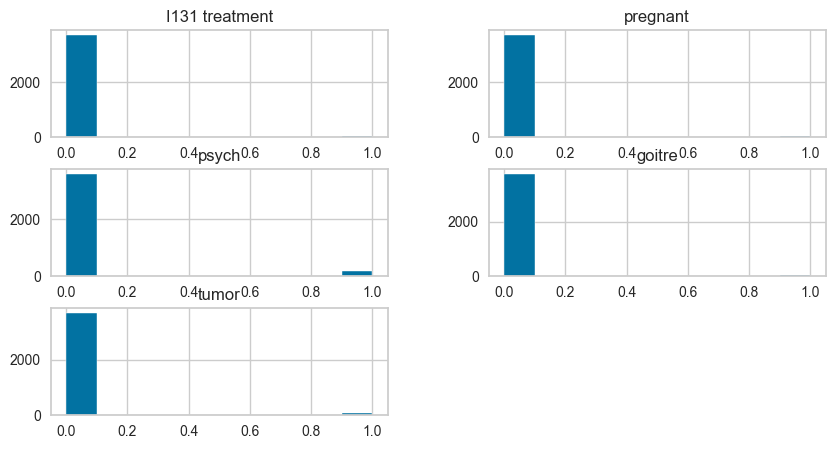

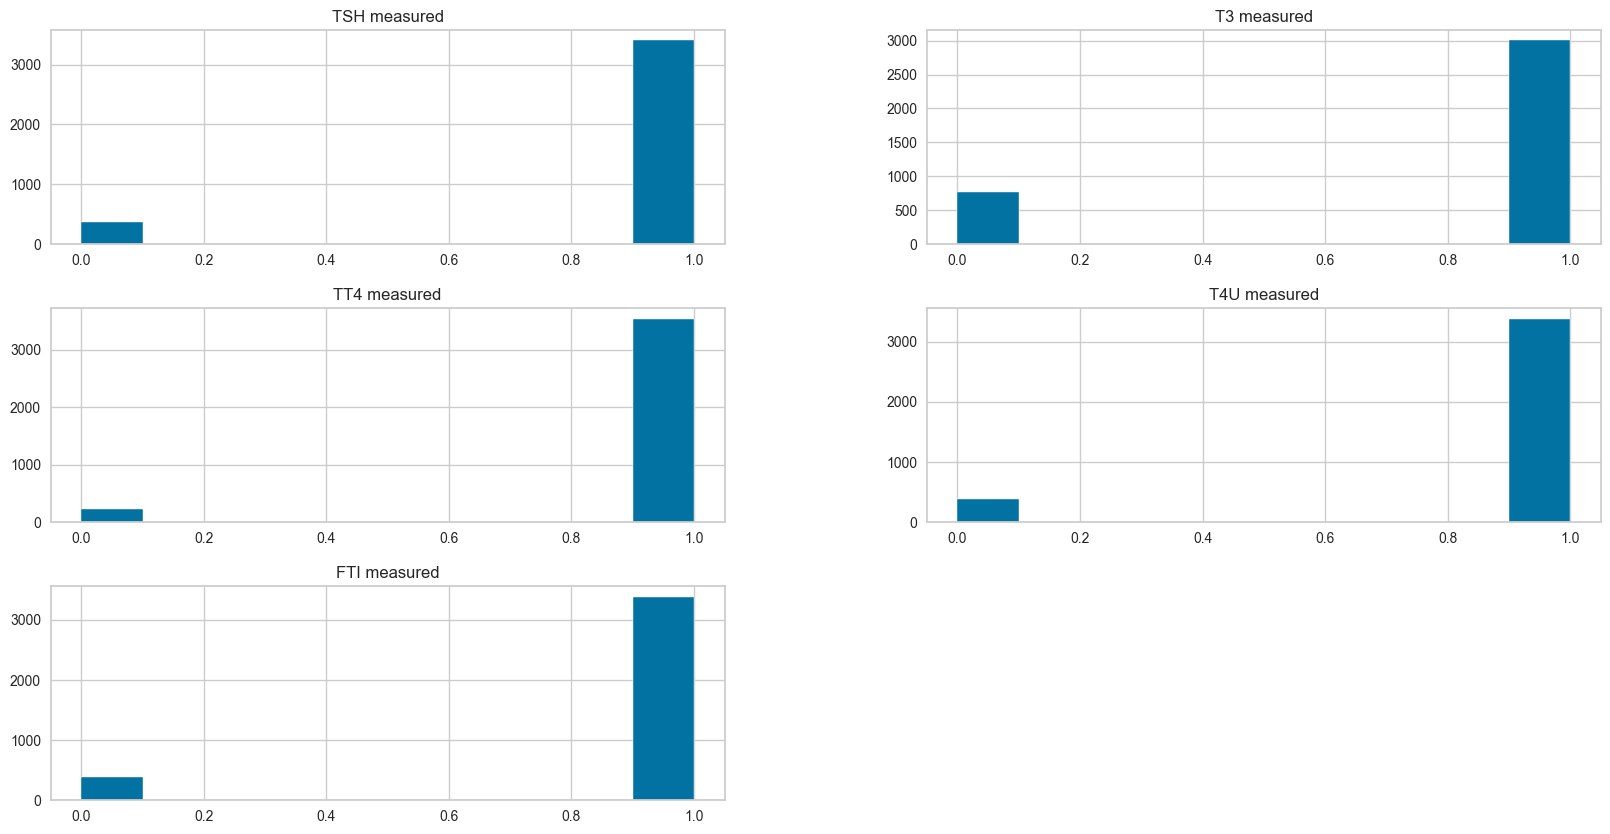

In [121]:
#df.hist(figsize=(40,30));

fig, ax = plt.subplots(figsize=(10,5))
df.loc[:,['I131 treatment','pregnant', 'psych', 'goitre', 'tumor']].hist(ax=ax);

# Save the figure
fig.savefig('hist-categoriques-totes-cat.png')

fig, ax = plt.subplots(figsize=(20,10))
df.loc[:,['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured']].hist(ax=ax);

# Save the figure
fig.savefig('hist-categoriques-totes-cat-hormones.png')

#### Comprobaremos si algunas de nuestras variables numéricas siguen una distribución Normal.

In [122]:
print(normaltest(df['age'], nan_policy='omit'))
print(normaltest(df['T3'], nan_policy='omit'))
print(normaltest(df['TT4'], nan_policy='omit'))
print(normaltest(df['T4U'], nan_policy='omit'))
print(normaltest(df['FTI'], nan_policy='omit'))

NormaltestResult(statistic=2297.2359679721785, pvalue=0.0)
NormaltestResult(statistic=1281.283371012964, pvalue=5.927220820727865e-279)
NormaltestResult(statistic=1076.7355223344223, pvalue=1.5482892216320525e-234)
NormaltestResult(statistic=865.0220675056678, pvalue=1.4549386431045578e-188)
NormaltestResult(statistic=1134.316352555169, pvalue=4.856614993979019e-247)


#### Asimismo podemos ver la posible normalidad de las variables usando los boxplots.

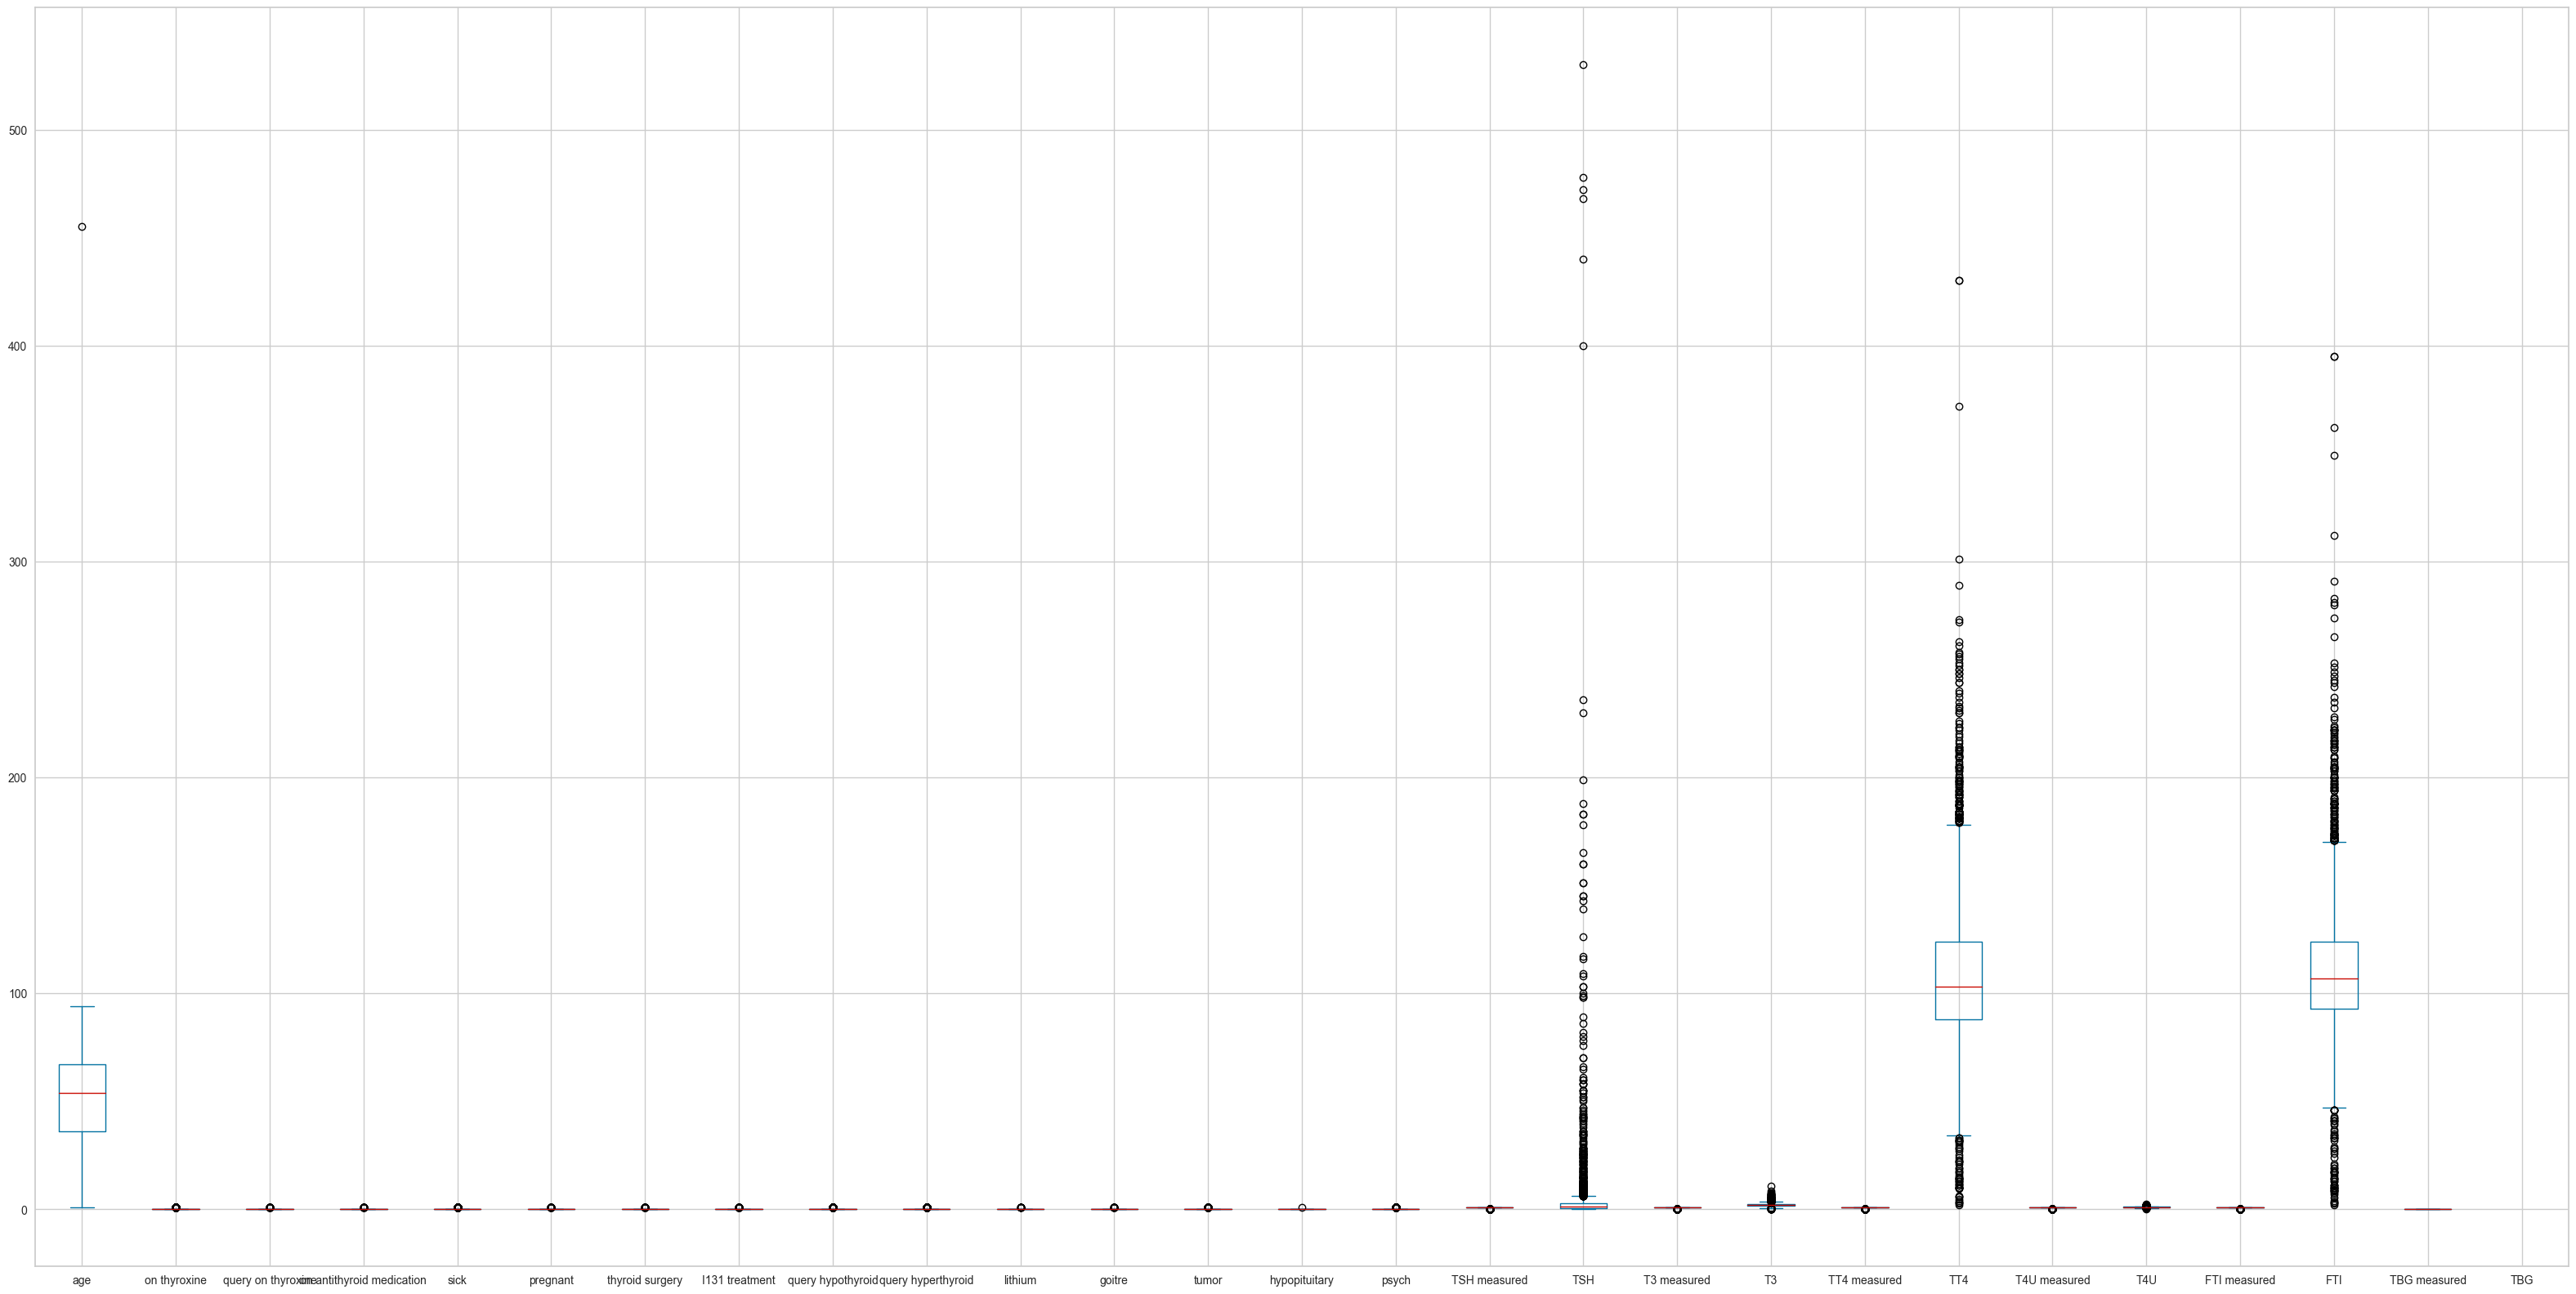

In [123]:
df.plot.box(figsize=(40,20));

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

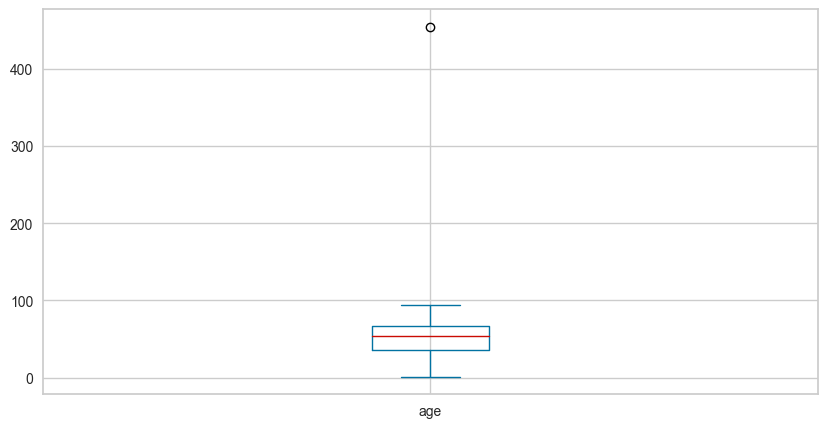

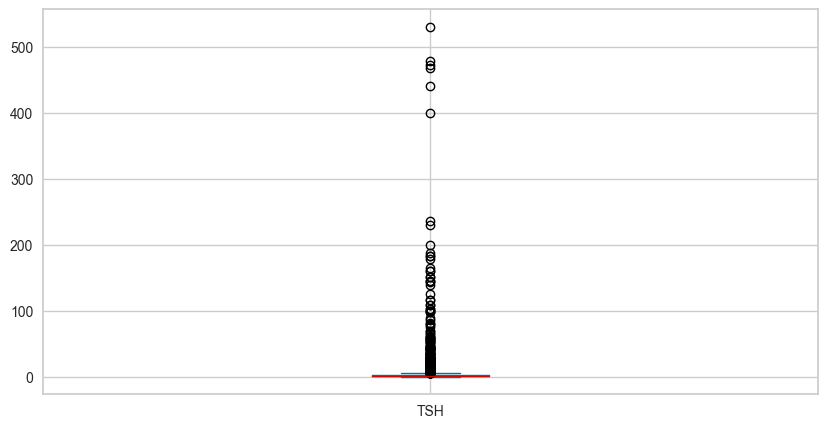

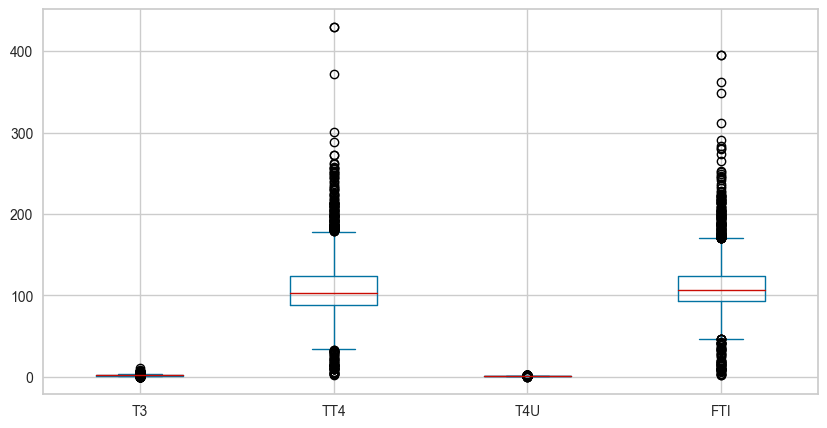

In [124]:
fig, ax = plt.subplots(figsize=(10,5))
df['age'].plot.box(ax=ax)

# Save the figure
fig.savefig('boxplot.png')


fig, ax = plt.subplots(figsize=(10,5))
df['TSH'].plot.box(ax=ax)

# Save the figure
fig.savefig('boxplot-TSH.png')



fig, ax = plt.subplots(figsize=(10,5))
df.loc[:,['T3', 'TT4', 'T4U', 'FTI']].plot.box(ax=ax);

# Save the figure
fig.savefig('boxplot-totes.png')

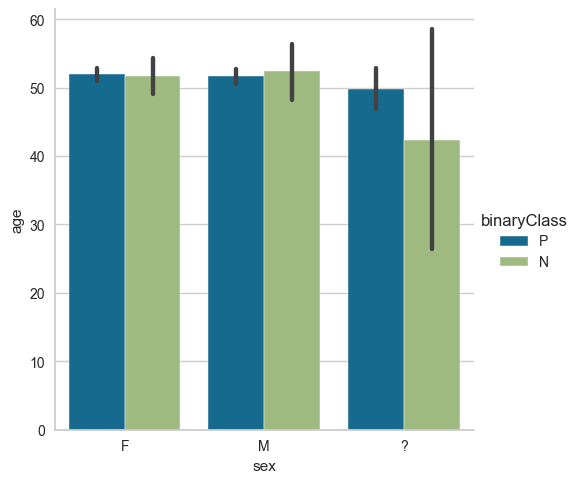

In [125]:
grafic = sns.catplot(data=df, kind="bar", x="sex", y="age", hue="binaryClass")

#### Correlación entre distintas variables

(<Figure size 1500x1500 with 1 Axes>, <AxesSubplot: >)

<AxesSubplot: >

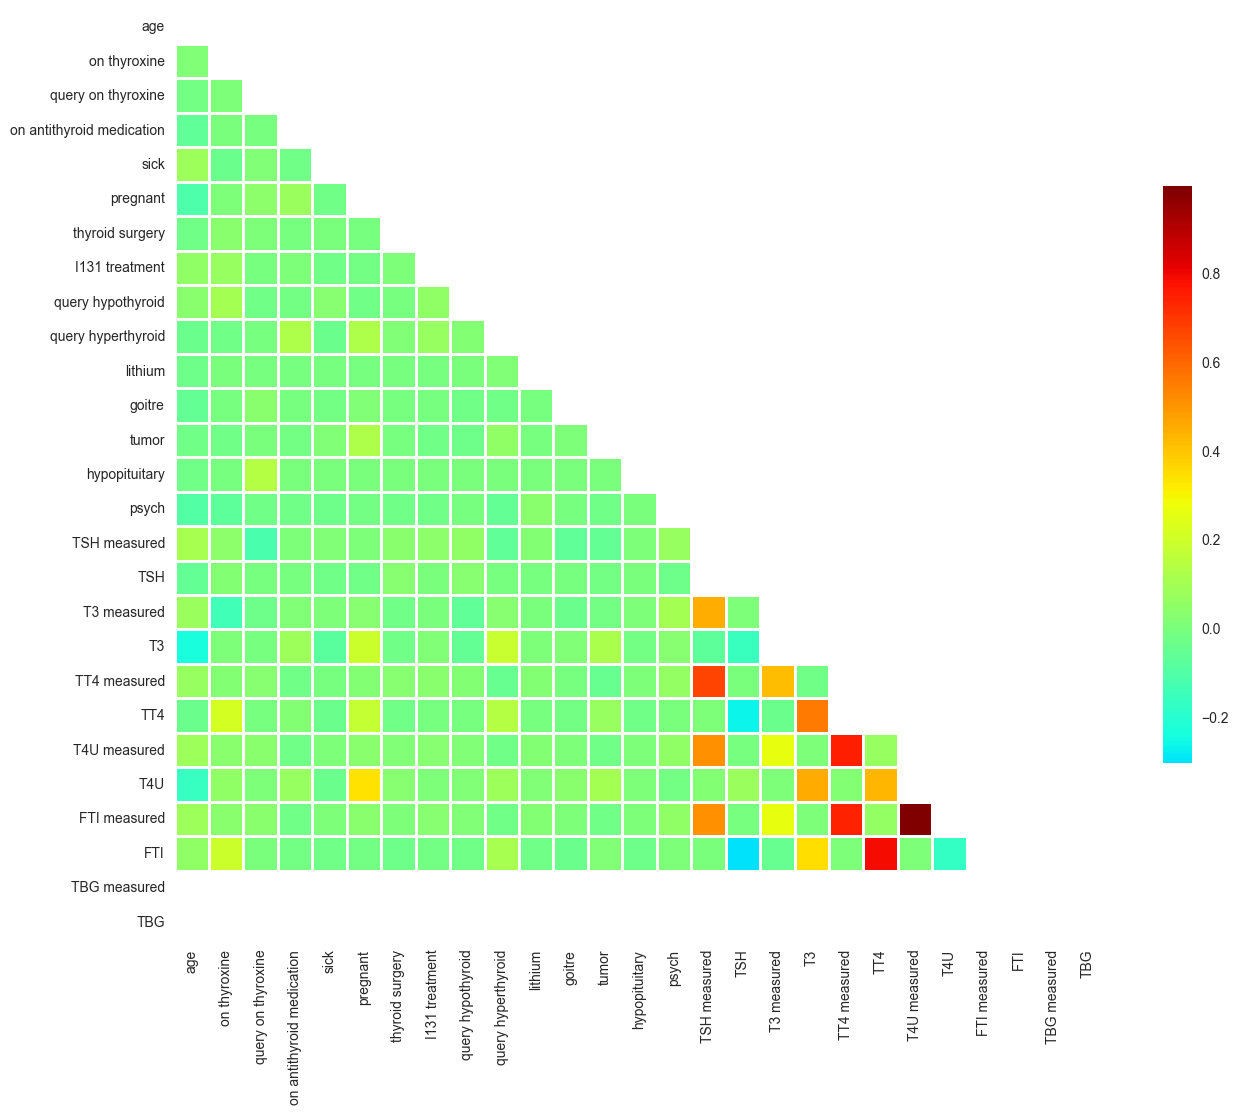

In [126]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap='jet',  center=0, square=True, linewidths=.8, cbar_kws={"shrink": .5});
plt.savefig('correlation_heatmap.png')

### Partición del conjunto de datos en el conjunto de entrenamiento y el conjunto de test

Hemos decidido hacer una partición del 80%/20% para nuestro conjunto de entrenamiento y test respectivamente. 

El razonamiento detrás del uso de una división del 70 %/30 % es que proporciona un buen equilibrio entre la cantidad de datos utilizados para el entrenamiento y la cantidad de datos utilizados para las pruebas. 

El uso de una mayor proporción de datos para el entrenamiento (por ejemplo, 80 %/20 %) puede permitirle construir un modelo más complejo, pero también significa que tiene menos datos para realizar pruebas, lo que puede no ser suficiente para evaluar con precisión el rendimiento de tu modelo Por otro lado, usar una proporción más pequeña de datos para el entrenamiento (por ejemplo, 60 %/40 %) puede resultar en un modelo más simple, pero también significa que tiene más datos para probar, lo que puede proporcionar una evaluación más sólida de su modelo.

En última instancia, la elección de la división de entrenamiento/prueba dependerá de las necesidades y restricciones específicas de su aplicación, y puede ser beneficioso probar algunas divisiones diferentes para ver cómo afectan el rendimiento de su modelo.

In [127]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['binaryClass'])

y_train = df.loc[X_train.index, 'binaryClass']
y_test = df.loc[X_test.index, 'binaryClass']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3017, 30), (755, 30), (3017,), (755,))

#### Para comprobar si el parámetro stratify funciona

In [128]:
df['binaryClass'].value_counts(normalize=True)

P    0.922853
N    0.077147
Name: binaryClass, dtype: float64

In [129]:
df['referral source'].value_counts()

other    2201
SVI      1034
SVHC      386
STMW      112
SVHD       39
Name: referral source, dtype: int64

In [130]:
y_train.value_counts(normalize=True)

P    0.922771
N    0.077229
Name: binaryClass, dtype: float64

In [131]:
y_test.value_counts(normalize=True)

P    0.923179
N    0.076821
Name: binaryClass, dtype: float64

In [132]:
y_train, X_train

(538     P
 3406    P
 2582    P
 759     P
 3549    P
        ..
 2761    P
 1505    N
 3683    P
 81      P
 3526    P
 Name: binaryClass, Length: 3017, dtype: object,
      binaryClass   age sex  on thyroxine  query on thyroxine  \
 538            P  73.0   F             0                   0   
 3406           P  27.0   F             0                   0   
 2582           P  25.0   F             0                   0   
 759            P  64.0   F             0                   0   
 3549           P  16.0   F             0                   0   
 ...          ...   ...  ..           ...                 ...   
 2761           P  35.0   M             0                   0   
 1505           N  41.0   M             0                   0   
 3683           P  21.0   F             0                   0   
 81             P  72.0   F             0                   1   
 3526           P  33.0   M             0                   0   
 
       on antithyroid medication  sick  pregnant

### Primero haremos un preproceso del conjunto de entrenamiento y luego un preprocesamiento del conjunto de test

### Conjunto de entrenamiento

Vemos como nos ha quedado el conjunto de entrenamiento

In [133]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 538 to 3526
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3017 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3017 non-null   object 
 3   on thyroxine               3017 non-null   int64  
 4   query on thyroxine         3017 non-null   int64  
 5   on antithyroid medication  3017 non-null   int64  
 6   sick                       3017 non-null   int64  
 7   pregnant                   3017 non-null   int64  
 8   thyroid surgery            3017 non-null   int64  
 9   I131 treatment             3017 non-null   int64  
 10  query hypothyroid          3017 non-null   int64  
 11  query hyperthyroid         3017 non-null   int64  
 12  lithium                    3017 non-null   int64  
 13  goitre                     3017 non-null   int

#### Contamos cuantos valores perdidos con NaN tenemos:

In [134]:
X_train.isna().sum()

binaryClass                     0
age                             1
sex                             0
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           296
T3 measured                     0
T3                            619
TT4 measured                    0
TT4                           184
T4U measured                    0
T4U                           315
FTI measured                    0
FTI                           315
TBG measured                    0
TBG                          3017
referral sourc

<AxesSubplot: >

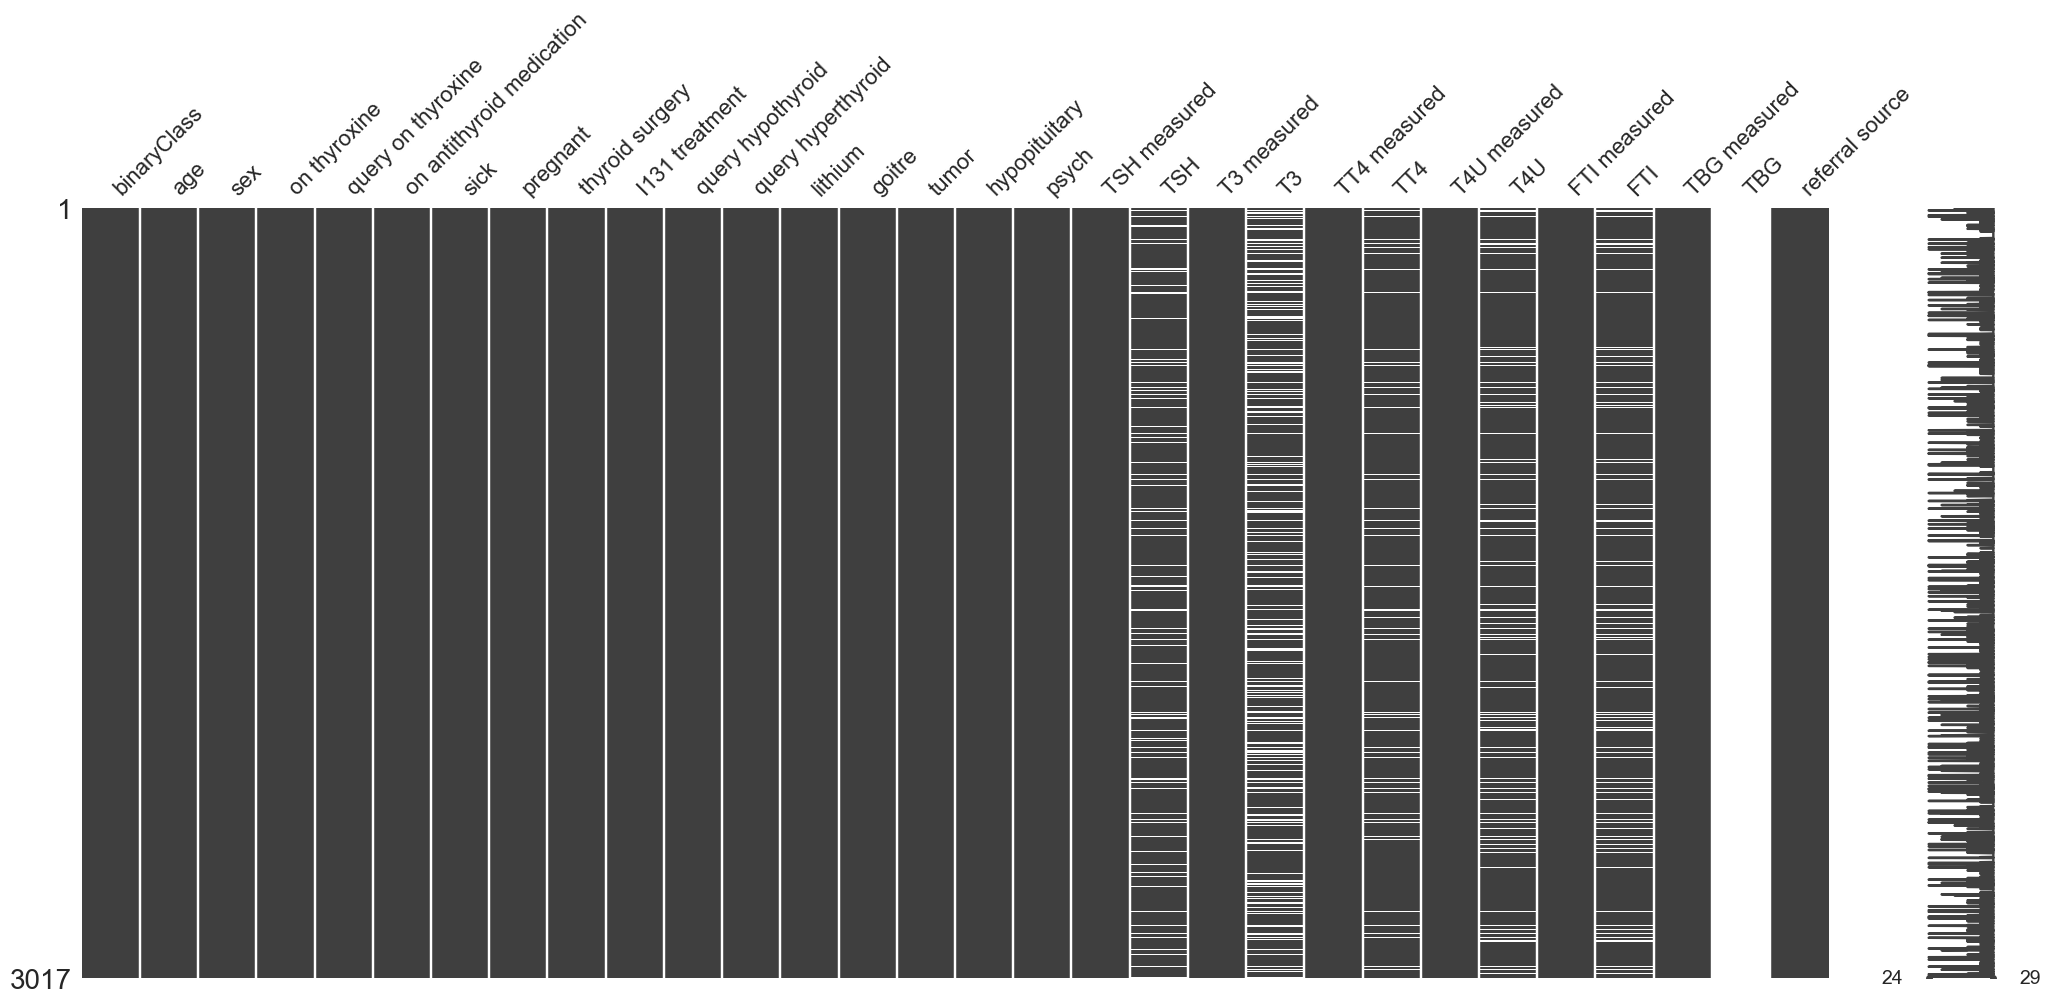

In [135]:
msno.matrix(X_train)

#### Procedemos al preprocesamiento de los datos

Hemos de tratar los atributos:binaryClass, age, sex, TSH, T3, T4U, TT4, FTI, TBG y referral source

##### Atributo age

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 538 to 3526
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   int

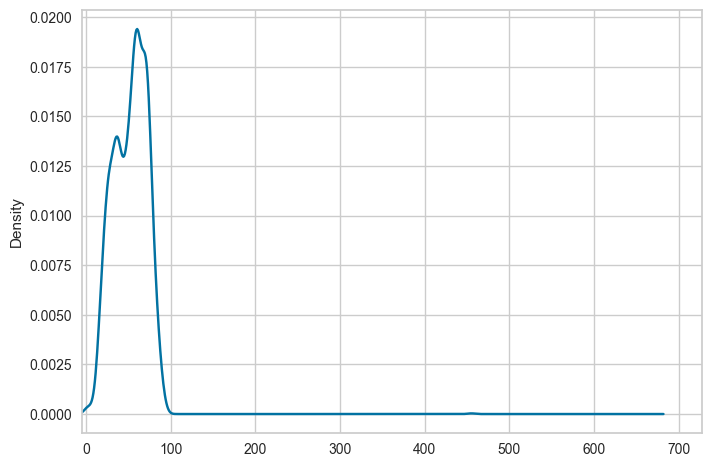

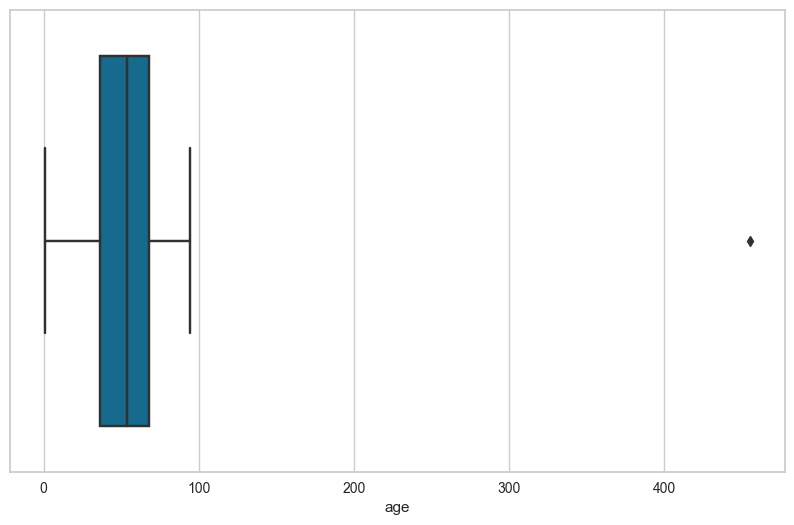

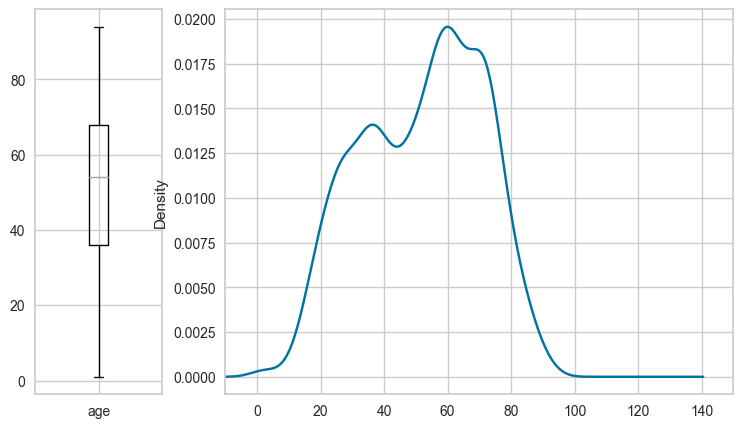

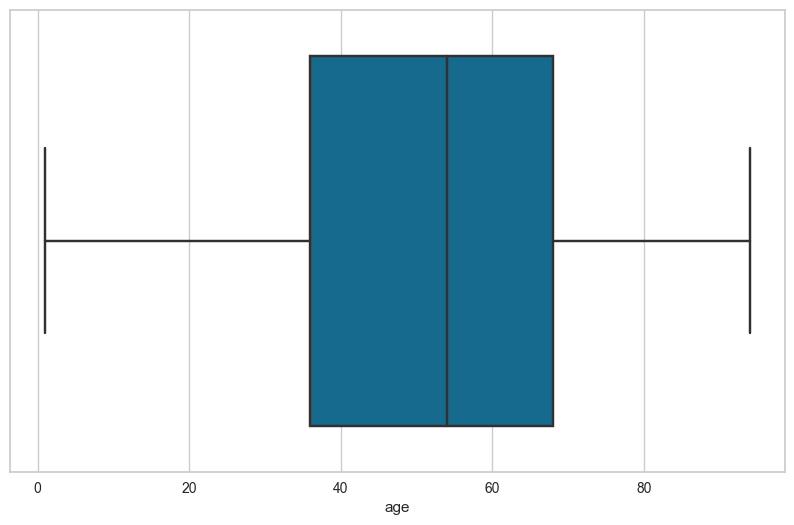

In [136]:
X_train['age'].plot.kde().set_xlim(left=-5)
X_train['age'].mean()
X_train['age'].std()

X_train['age'].fillna(value=X_train['age'].mean(), inplace=True)

#outlier detectado en la columna de age, quitamos la fila del outlier:
plt.figure(figsize=(10,6))
sns.boxplot(data=X_train, x="age")

Q1 = X_train['age'].quantile(0.25)
Q3 = X_train['age'].quantile(0.75)
IQR = Q3 - Q1

# Q1, Q3, IQR

small_outliers = X_train['age'] < (Q1 - 1.5 * IQR)
big_outliers = X_train['age'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

X_train['age'] [small_outliers | big_outliers].head()
X_train.drop([1364], inplace=True)
X_train.info()

#quitamos los outliers
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
X_train[~(small_outliers | big_outliers)].boxplot(column='age',ax=axes[0])
X_train[~(small_outliers | big_outliers)]['age'].plot.kde().set_xlim(left=-10)

X_train['age'].mean()
X_train['age'].std()

#Lo hemos quitado exitosamente
plt.figure(figsize=(10,6))
sns.boxplot(data=X_train, x="age");

In [137]:
X_train.isna().sum()

binaryClass                     0
age                             0
sex                             0
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           296
T3 measured                     0
T3                            619
TT4 measured                    0
TT4                           184
T4U measured                    0
T4U                           315
FTI measured                    0
FTI                           315
TBG measured                    0
TBG                          3016
referral sourc

#### Atributo TBG y referral source

Quitamos ambas columnas ya que la columna TBG tiene todos sus valores a NaN y por lo tanto no nos pueden servir para predecir la variable respuesta. 

Y quitamos la variable referral source que es una variable categorica que dispone de hasta 5 valores únicos:  SVHC,other,SVI,STMW,SVHD

In [138]:
#tratamos la columna TBG
X_train.drop('TBG', inplace=True, axis=1)
X_train.info()
X_train.isna().sum()

#tratamos la columna TBG measured
X_train.drop('TBG measured', inplace=True, axis=1)
X_train.info()
X_train.isna().sum()

#tratamos la columna referral source
X_train.drop('referral source', inplace=True, axis=1)
X_train.info()
X_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 538 to 3526
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   int

binaryClass                    0
age                            0
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          296
T3 measured                    0
T3                           619
TT4 measured                   0
TT4                          184
T4U measured                   0
T4U                          315
FTI measured                   0
FTI                          315
TBG measured                   0
referral source                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 538 to 3526
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   int

binaryClass                    0
age                            0
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          296
T3 measured                    0
T3                           619
TT4 measured                   0
TT4                          184
T4U measured                   0
T4U                          315
FTI measured                   0
FTI                          315
referral source                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 538 to 3526
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   int

binaryClass                    0
age                            0
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          296
T3 measured                    0
T3                           619
TT4 measured                   0
TT4                          184
T4U measured                   0
T4U                          315
FTI measured                   0
FTI                          315
dtype: int64

##### Atributo sex

La categoria ? nos muestra que no sabemos el sexo del paciente asi que supondremos que es una mujer ya que tenemos un valor para esta categoria mayor.

In [139]:
#convertimos la variable de 'sex'
X_train['sex'].unique()
X_train['sex'].value_counts()

X_train.replace(to_replace='?', inplace=True, value='F')
X_train['sex'] = X_train['sex'].astype('category').cat.codes

X_train['sex'].unique()
X_train['sex'].value_counts()

array(['F', 'M', '?'], dtype=object)

F    1992
M     902
?     122
Name: sex, dtype: int64

array([0, 1], dtype=int8)

0    2114
1     902
Name: sex, dtype: int64

##### Atributo binaryClass

Convertimos la variable respuesta a binaria

In [140]:
X_train['binaryClass'].unique()
X_train['binaryClass'].value_counts()

X_train['binaryClass'] = X_train['binaryClass'].astype('category').cat.codes

X_train.info()

array(['P', 'N'], dtype=object)

P    2783
N     233
Name: binaryClass, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 538 to 3526
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   int8   
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   int8   
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   int

##### Atributos: TSH, T3, T4U, TT4, FTI

En cuánto a los missing values, los inferiremos con la mediana de cadauno de ellos.

In [141]:
X_train['TSH'].fillna(value=X_train['TSH'].mean(), inplace = True)
X_train['T3'].fillna(value=X_train['T3'].mean(), inplace = True)
X_train['TT4'].fillna(value=X_train['TT4'].mean(), inplace = True)
X_train['T4U'].fillna(value=X_train['T4U'].mean(), inplace = True)
X_train['FTI'].fillna(value=X_train['FTI'].mean(), inplace = True)

#### Ya hemos limpiado el conjunto de entrenamiento

In [142]:
X_train.describe()
X_train.isna().sum()

,binaryClass,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI
count,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,...,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000
mean,0.922745,51.892913,0.299072,0.123674,0.013594,0.012599,0.037467,0.015252,0.013594,0.017241,...,0.901857,5.244829,0.794761,2.013517,0.938992,108.497811,0.895557,0.995851,0.895557,110.575231
std,0.267039,19.022902,0.457927,0.329264,0.115818,0.111556,0.189934,0.122574,0.115818,0.130191,...,0.297558,25.118371,0.403943,0.733008,0.239385,34.699149,0.305885,0.186938,0.305885,31.361514
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005000,0.000000,0.100000,0.000000,2.000000,0.000000,0.250000,0.000000,2.000000
25%,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.600000,1.000000,1.700000,1.000000,89.000000,1.000000,0.890000,1.000000,94.000000
50%,1.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.600000,1.000000,2.013517,1.000000,106.000000,1.000000,0.995851,1.000000,110.000000
75%,1.000000,68.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,3.700000,1.000000,2.300000,1.000000,123.000000,1.000000,1.070000,1.000000,122.000000
max,1.000000,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,530.000000,1.000000,10.600000,1.000000,430.000000,1.000000,2.320000,1.000000,395.000000


binaryClass                  0
age                          0
sex                          0
on thyroxine                 0
query on thyroxine           0
on antithyroid medication    0
sick                         0
pregnant                     0
thyroid surgery              0
I131 treatment               0
query hypothyroid            0
query hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH measured                 0
TSH                          0
T3 measured                  0
T3                           0
TT4 measured                 0
TT4                          0
T4U measured                 0
T4U                          0
FTI measured                 0
FTI                          0
dtype: int64

### Conjunto de test

Vemos como nos ha quedado el conjunto de test

In [143]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 1123 to 1917
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                755 non-null    object 
 1   age                        755 non-null    float64
 2   sex                        755 non-null    object 
 3   on thyroxine               755 non-null    int64  
 4   query on thyroxine         755 non-null    int64  
 5   on antithyroid medication  755 non-null    int64  
 6   sick                       755 non-null    int64  
 7   pregnant                   755 non-null    int64  
 8   thyroid surgery            755 non-null    int64  
 9   I131 treatment             755 non-null    int64  
 10  query hypothyroid          755 non-null    int64  
 11  query hyperthyroid         755 non-null    int64  
 12  lithium                    755 non-null    int64  
 13  goitre                     755 non-null    int

#### Contamos cuantos valores perdidos con NaN tenemos:

In [144]:
X_test.isna().sum()

binaryClass                    0
age                            0
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                           73
T3 measured                    0
T3                           150
TT4 measured                   0
TT4                           47
T4U measured                   0
T4U                           72
FTI measured                   0
FTI                           70
TBG measured                   0
TBG                          755
referral source                0
dtype: int

<AxesSubplot: >

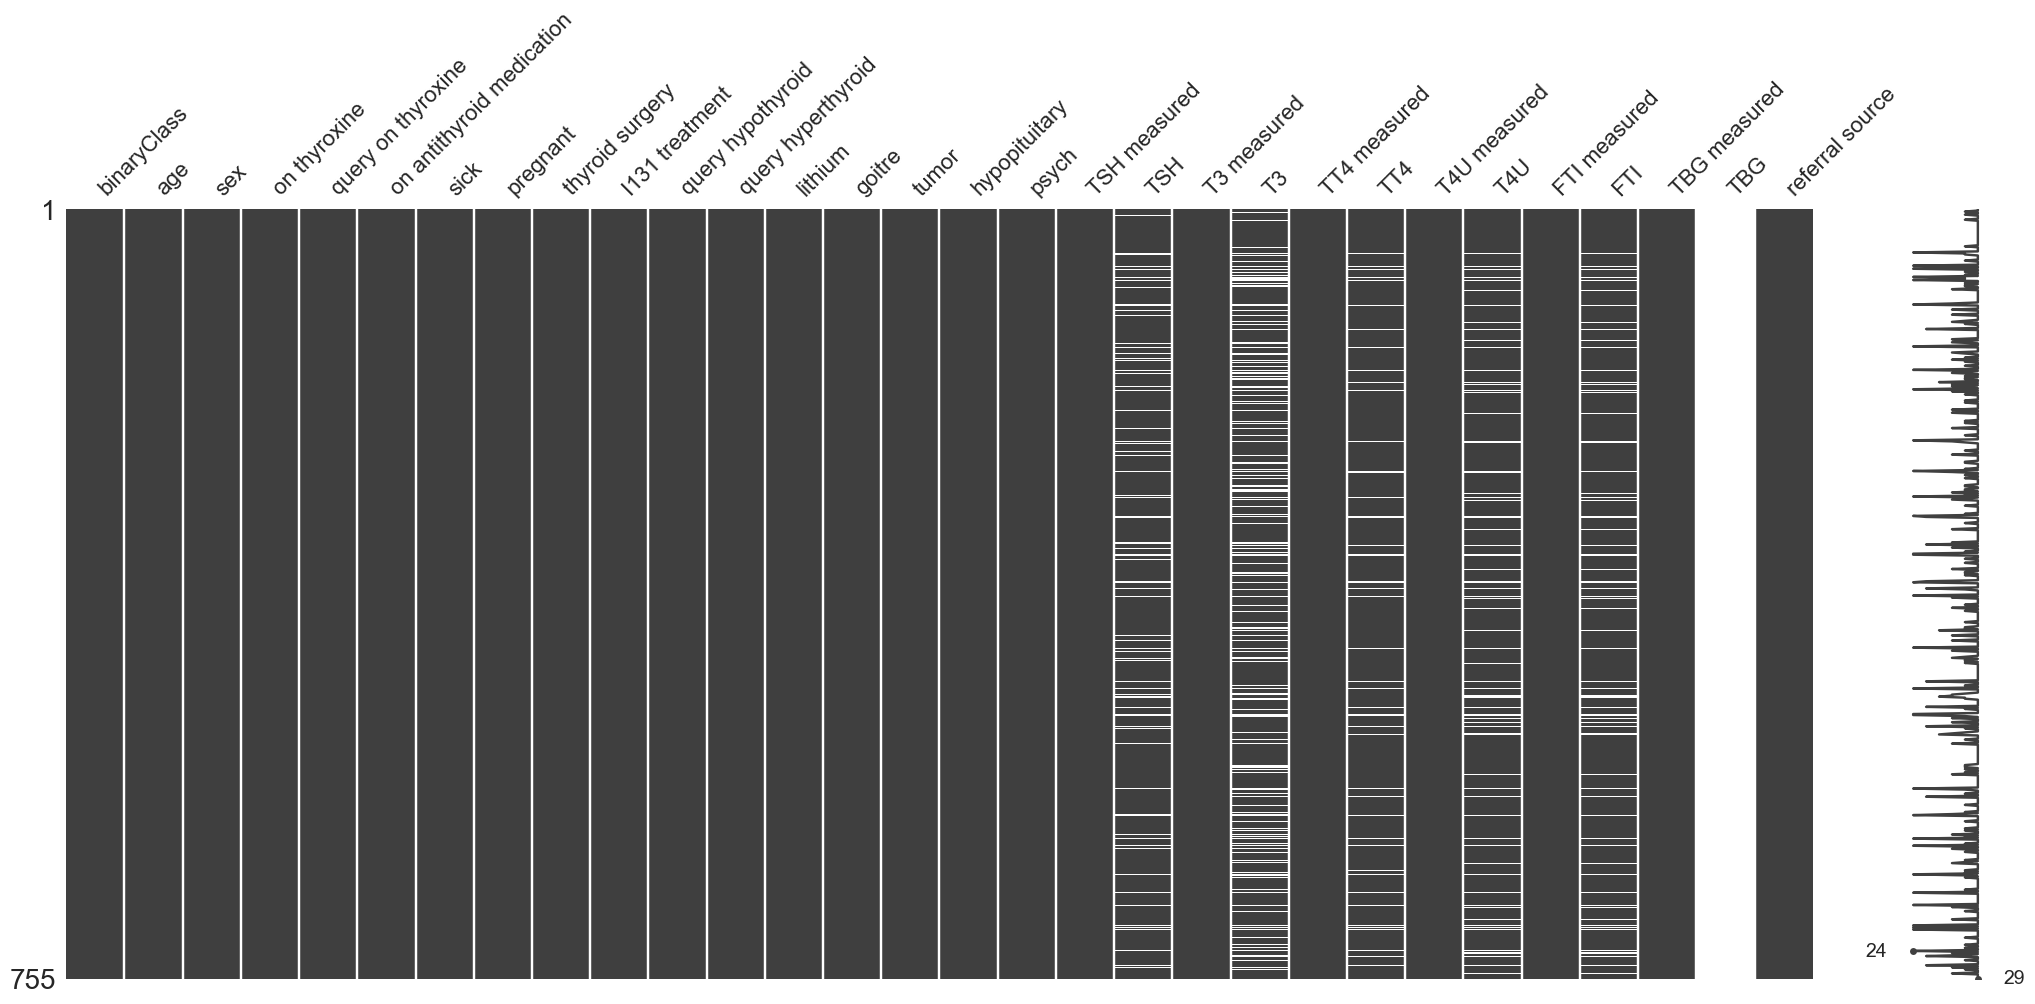

In [145]:
msno.matrix(X_test)

#### Procedemos al preprocesamiento de los datos

##### Eliminamos atributo TBG y referral source

In [146]:
X_test.drop('TBG', inplace=True, axis=1)
X_test.drop('TBG measured', inplace=True, axis=1)
X_test.drop('referral source', inplace=True, axis=1)

##### Atributo sex

Análogamente a como hemos hecho con el conjunto de entrenamiento, tratamos la categoria ?(muestra que no sabemos el sexo del paciente) suponiendo que es una mujer ya que tenemos un valor para esta categoriaxx

In [147]:
#convertimos la variable de 'sex'
X_test['sex'].unique()
X_test['sex'].value_counts()

X_test.replace(to_replace='?', inplace=True, value='F')
X_test['sex'] = X_test['sex'].astype('category').cat.codes

X_test['sex'].unique()
X_test['sex'].value_counts()

array(['M', '?', 'F'], dtype=object)

F    487
M    240
?     28
Name: sex, dtype: int64

array([1, 0], dtype=int8)

0    515
1    240
Name: sex, dtype: int64

##### Atributo binaryClass

Convertimos la variable binaryClass

In [148]:
X_test['binaryClass'].unique()
X_test['binaryClass'].value_counts()

X_test['binaryClass'] = X_test['binaryClass'].astype('category').cat.codes

array(['P', 'N'], dtype=object)

P    697
N     58
Name: binaryClass, dtype: int64

##### Atributos: TSH, T3, T4U, TT4, FTI

Modificamos los NaN que quedan de los atributos que son proteinas de nuestro conjunto de test

In [149]:
X_test['TSH'].fillna(value=X_test['TSH'].mean(), inplace = True)
X_test['T3'].fillna(value=X_test['T3'].mean(), inplace = True)
X_test['TT4'].fillna(value=X_test['TT4'].mean(), inplace = True)
X_test['T4U'].fillna(value=X_test['T4U'].mean(), inplace = True)
X_test['FTI'].fillna(value=X_test['FTI'].mean(), inplace = True)

#### Ya hemos limpiado el conjunto de entrenamiento

In [150]:
X_test.describe()
X_test.isna().sum()

,binaryClass,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,...,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,0.923179,50.574834,0.317881,0.120530,0.011921,0.006623,0.045033,0.009272,0.015894,0.009272,...,0.903311,4.462214,0.801325,2.013455,0.937748,107.591808,0.904636,0.991435,0.907285,110.062774
std,0.266484,18.785559,0.465962,0.325796,0.108600,0.081163,0.207514,0.095905,0.125149,0.095905,...,0.295729,13.772479,0.399268,0.759859,0.241772,33.709892,0.293912,0.178001,0.290225,31.367047
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005000,0.000000,0.050000,0.000000,3.000000,0.000000,0.410000,0.000000,3.000000
25%,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.600000,1.000000,1.700000,1.000000,89.000000,1.000000,0.890000,1.000000,95.000000
50%,1.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.600000,1.000000,2.013455,1.000000,105.000000,1.000000,0.991435,1.000000,110.000000
75%,1.000000,65.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,3.950000,1.000000,2.200000,1.000000,121.000000,1.000000,1.065000,1.000000,121.000000
max,1.000000,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,188.000000,1.000000,8.500000,1.000000,430.000000,1.000000,1.940000,1.000000,395.000000


binaryClass                  0
age                          0
sex                          0
on thyroxine                 0
query on thyroxine           0
on antithyroid medication    0
sick                         0
pregnant                     0
thyroid surgery              0
I131 treatment               0
query hypothyroid            0
query hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH measured                 0
TSH                          0
T3 measured                  0
T3                           0
TT4 measured                 0
TT4                          0
T4U measured                 0
T4U                          0
FTI measured                 0
FTI                          0
dtype: int64

### Guardamos los datasets limpios en unos nuevos csv donde guardaramos los conjuntos de entrenamiento y test 

In [151]:
X_train.to_csv('df_train.csv', index=False)
X_test.to_csv('df_test.csv', index=False)

### Dropeamos la variable respuesta de los conjuntos de datos de test y de training

#### Cargamos el csv de entrenamiento y etiquetamos en y_train la variable respuesta

In [152]:
#Conseguimos el csv de entrenamiento
y_train = X_train['binaryClass']

print(y_train.value_counts(normalize=True))

X_train.drop('binaryClass', axis=1, inplace = True)

1    0.922745
0    0.077255
Name: binaryClass, dtype: float64


#### Cargamos el csv de test y etiquetamos en y_test la variable respuesta

In [153]:
#Conseguimos el csv de test
y_test = X_test['binaryClass']

print(y_test.value_counts(normalize=True))

X_test.drop('binaryClass', axis=1, inplace = True)

1    0.923179
0    0.076821
Name: binaryClass, dtype: float64


#### Vemos cúantos ejemplos tenemos de cada clase en nuestro conjunto de entrenamiento y test

Vemos que tenemos una proporción de ejemplos casi idéntica en ambos conjuntos de datos

In [154]:
ejemplos_train = dict(zip(list(y_train),[list(y_train).count(i) for i in list(y_train)]))
ejemplos_train


ejemplos_test = dict(zip(list(y_test),[list(y_test).count(i) for i in list(y_test)]))
ejemplos_test

{1: 2783, 0: 233}

{1: 697, 0: 58}

#### Extraemos las etiquetas de las clase a las que vamos a clasificar los ejemplos

In [155]:
clases = [str(v) for v in sorted(np.unique(y_train))]
clases

['0', '1']

### Estudio de las características de los datos de entrenamiento

#### Calculando sus estadísticas

Podemos ver también la relación que hay entre las variables de las ventanas y el target utilizando la información mutua

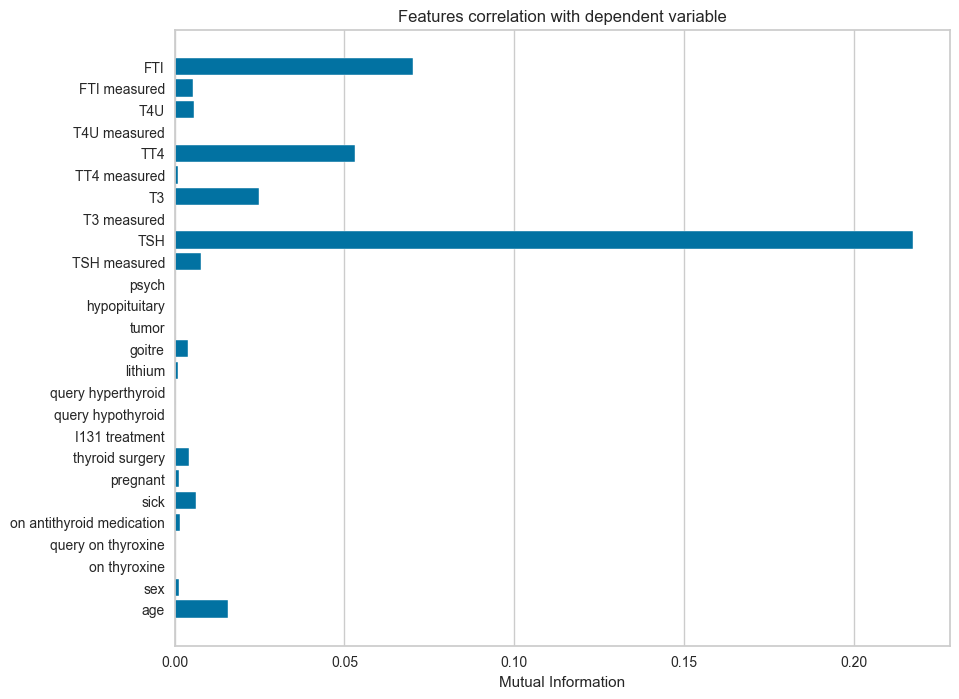

In [156]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns),method='mutual_info-classification');

(<Figure size 1000x800 with 1 Axes>, <AxesSubplot: >)

<AxesSubplot: >

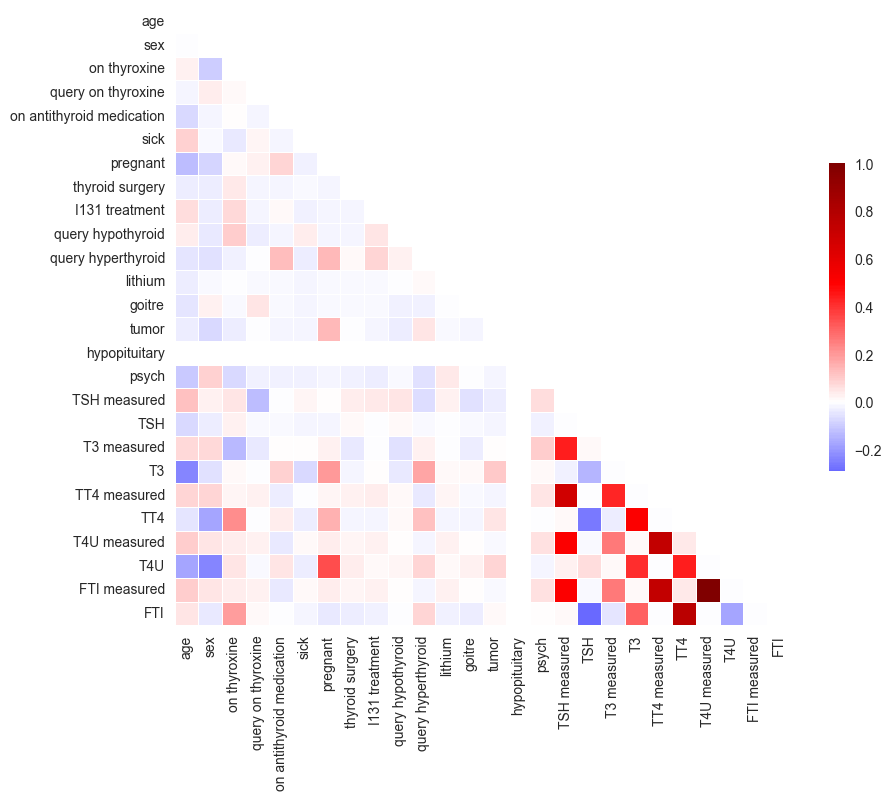

In [157]:
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

plt.savefig('correlation_heatmap-train.png')

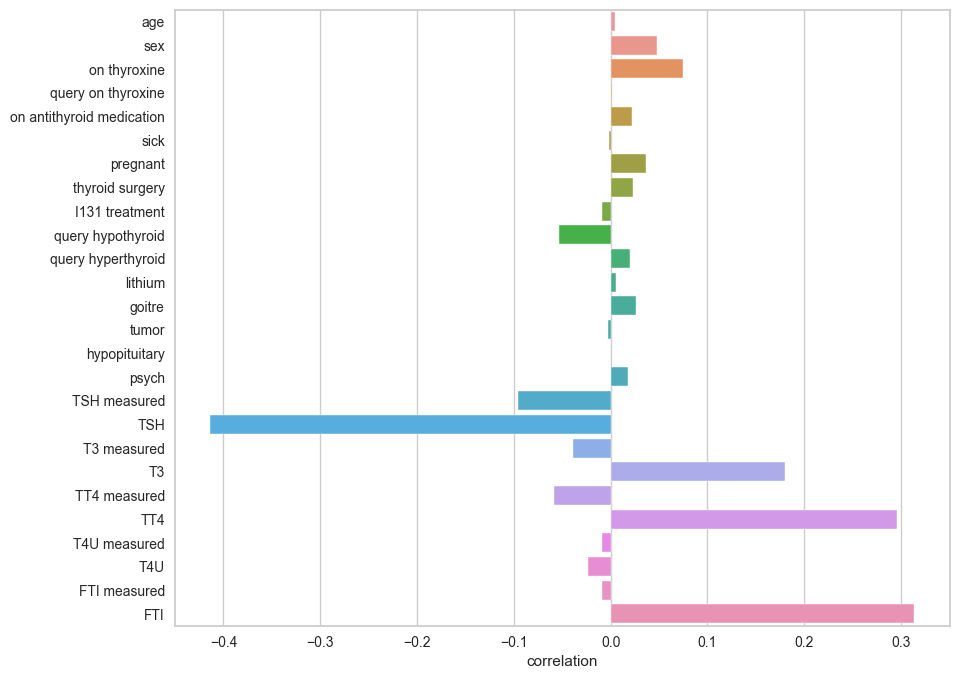

In [158]:
def feature_correlation(X, y, labels, method='pearson'):
    corr = X.corrwith(y, method=method)
    corr_df = pd.DataFrame(corr, columns=['correlation'])
    fig, ax = plt.subplots(figsize=(10,8))
    sns.barplot(x=corr_df['correlation'], y=corr_df.index, ax=ax, orient='h')
    ax.set_yticklabels(labels, rotation=0)
    return fig

visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns), method='pearson');
plt.savefig('feature_correlation.png')

### Estandarizamos el conjunto de entrenamiento y test para poder aplicar después el PCA sobre los datos

In [159]:
X_train_standarized = X_train.copy()
scaler = MinMaxScaler()
X_train_standarized[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
age,3016.0,0.547236,0.204547,0.0,0.376344,0.569892,0.720430,1.0
sex,3016.0,0.299072,0.457927,0.0,0.000000,0.000000,1.000000,1.0
on thyroxine,3016.0,0.123674,0.329264,0.0,0.000000,0.000000,0.000000,1.0
query on thyroxine,3016.0,0.013594,0.115818,0.0,0.000000,0.000000,0.000000,1.0
on antithyroid medication,3016.0,0.012599,0.111556,0.0,0.000000,0.000000,0.000000,1.0
sick,3016.0,0.037467,0.189934,0.0,0.000000,0.000000,0.000000,1.0
pregnant,3016.0,0.015252,0.122574,0.0,0.000000,0.000000,0.000000,1.0
thyroid surgery,3016.0,0.013594,0.115818,0.0,0.000000,0.000000,0.000000,1.0
I131 treatment,3016.0,0.017241,0.130191,0.0,0.000000,0.000000,0.000000,1.0
query hypothyroid,3016.0,0.062666,0.242401,0.0,0.000000,0.000000,0.000000,1.0


In [160]:
X_test_standarized = X_test.copy()
X_test_standarized[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
age,755.0,0.533063,0.201995,0.000000,0.376344,0.559140,0.688172,1.000000
sex,755.0,0.317881,0.465962,0.000000,0.000000,0.000000,1.000000,1.000000
on thyroxine,755.0,0.120530,0.325796,0.000000,0.000000,0.000000,0.000000,1.000000
query on thyroxine,755.0,0.011921,0.108600,0.000000,0.000000,0.000000,0.000000,1.000000
on antithyroid medication,755.0,0.006623,0.081163,0.000000,0.000000,0.000000,0.000000,1.000000
sick,755.0,0.045033,0.207514,0.000000,0.000000,0.000000,0.000000,1.000000
pregnant,755.0,0.009272,0.095905,0.000000,0.000000,0.000000,0.000000,1.000000
thyroid surgery,755.0,0.015894,0.125149,0.000000,0.000000,0.000000,0.000000,1.000000
I131 treatment,755.0,0.009272,0.095905,0.000000,0.000000,0.000000,0.000000,1.000000
query hypothyroid,755.0,0.059603,0.236906,0.000000,0.000000,0.000000,0.000000,1.000000


#### El método PCA de scikit-learn devolverá la relación de varianza explicada y todos los parámetros importantes relacionados con PCA

In [161]:
myPCA = PCA().fit(X_train_standarized[X_train.columns]);

#PCA.explained_variance_ratio_ para comprender qué porcentaje de varianza explican los datos
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[2.58468767e-01 1.76816432e-01 1.16865732e-01 8.32737691e-02
 5.24769876e-02 4.99796687e-02 4.09671667e-02 3.82536260e-02
 3.19017231e-02 2.87322620e-02 2.01133105e-02 1.39306168e-02
 1.33817526e-02 1.30680852e-02 1.11342611e-02 1.00325583e-02
 9.92260486e-03 9.64107545e-03 6.61073834e-03 5.80326630e-03
 4.65055763e-03 2.19037988e-03 1.61594630e-03 1.68713160e-04
 2.42328528e-33 1.70516369e-33]
[0.25846877 0.4352852  0.55215093 0.6354247  0.68790169 0.73788136
 0.77884852 0.81710215 0.84900387 0.87773613 0.89784944 0.91178006
 0.92516181 0.9382299  0.94936416 0.95939672 0.96931932 0.9789604
 0.98557114 0.9913744  0.99602496 0.99821534 0.99983129 1.
 1.         1.        ]


#### Scree plot se usa para comprender la cantidad de componentes principales que se deben usar para capturar la varianza deseada en los datos

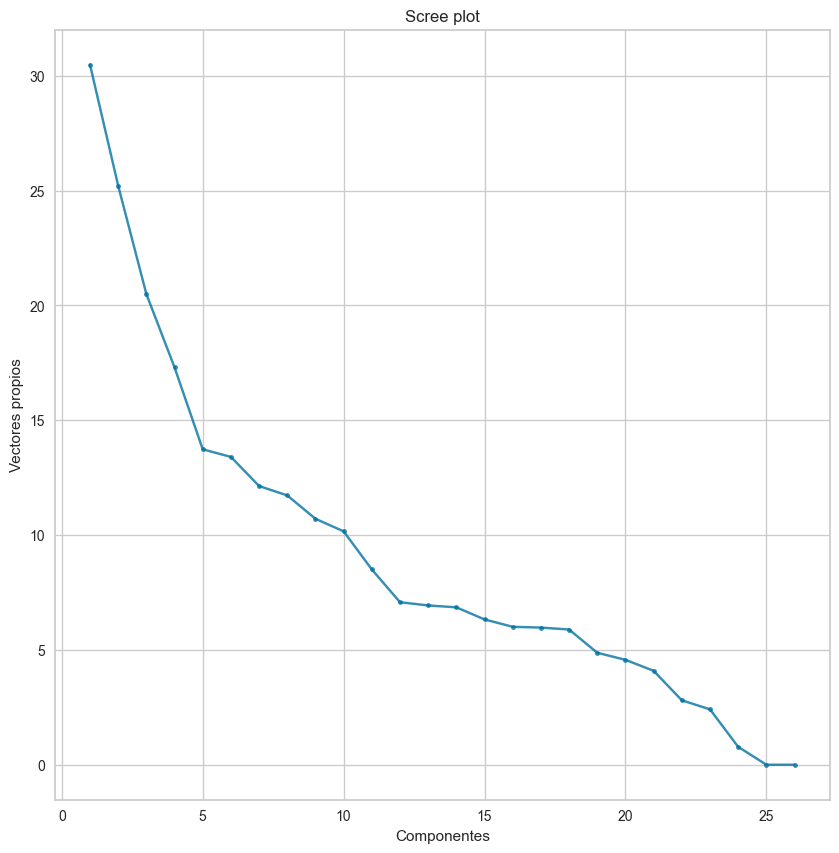

In [162]:
fig = plt.figure(figsize=(10,10));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
#La nueva base son los vectores propios de la matriz de covarianza.
y_label = plt.ylabel('Vectores propios');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

Text(0.5, 1.0, 'Porcentaje de variancia explicada por componente')

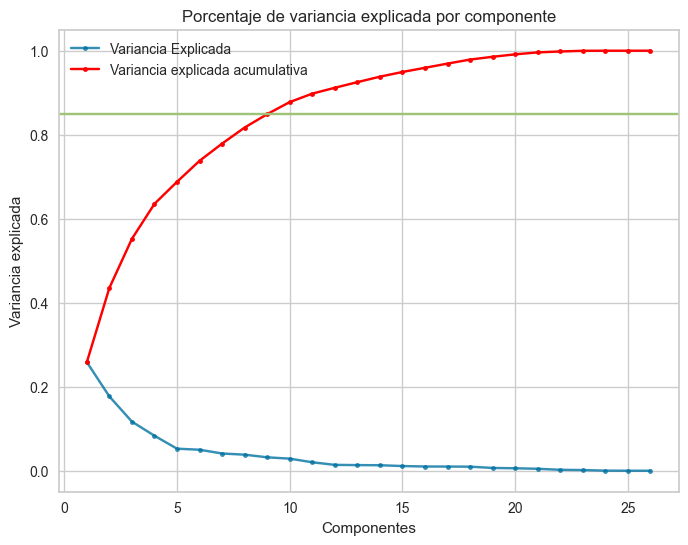

In [163]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');
plt.axhline(y=0.85, color='g', linestyle='-')

#### Pesos que le asigna el PCA a cada componente visualizado con un heatmap

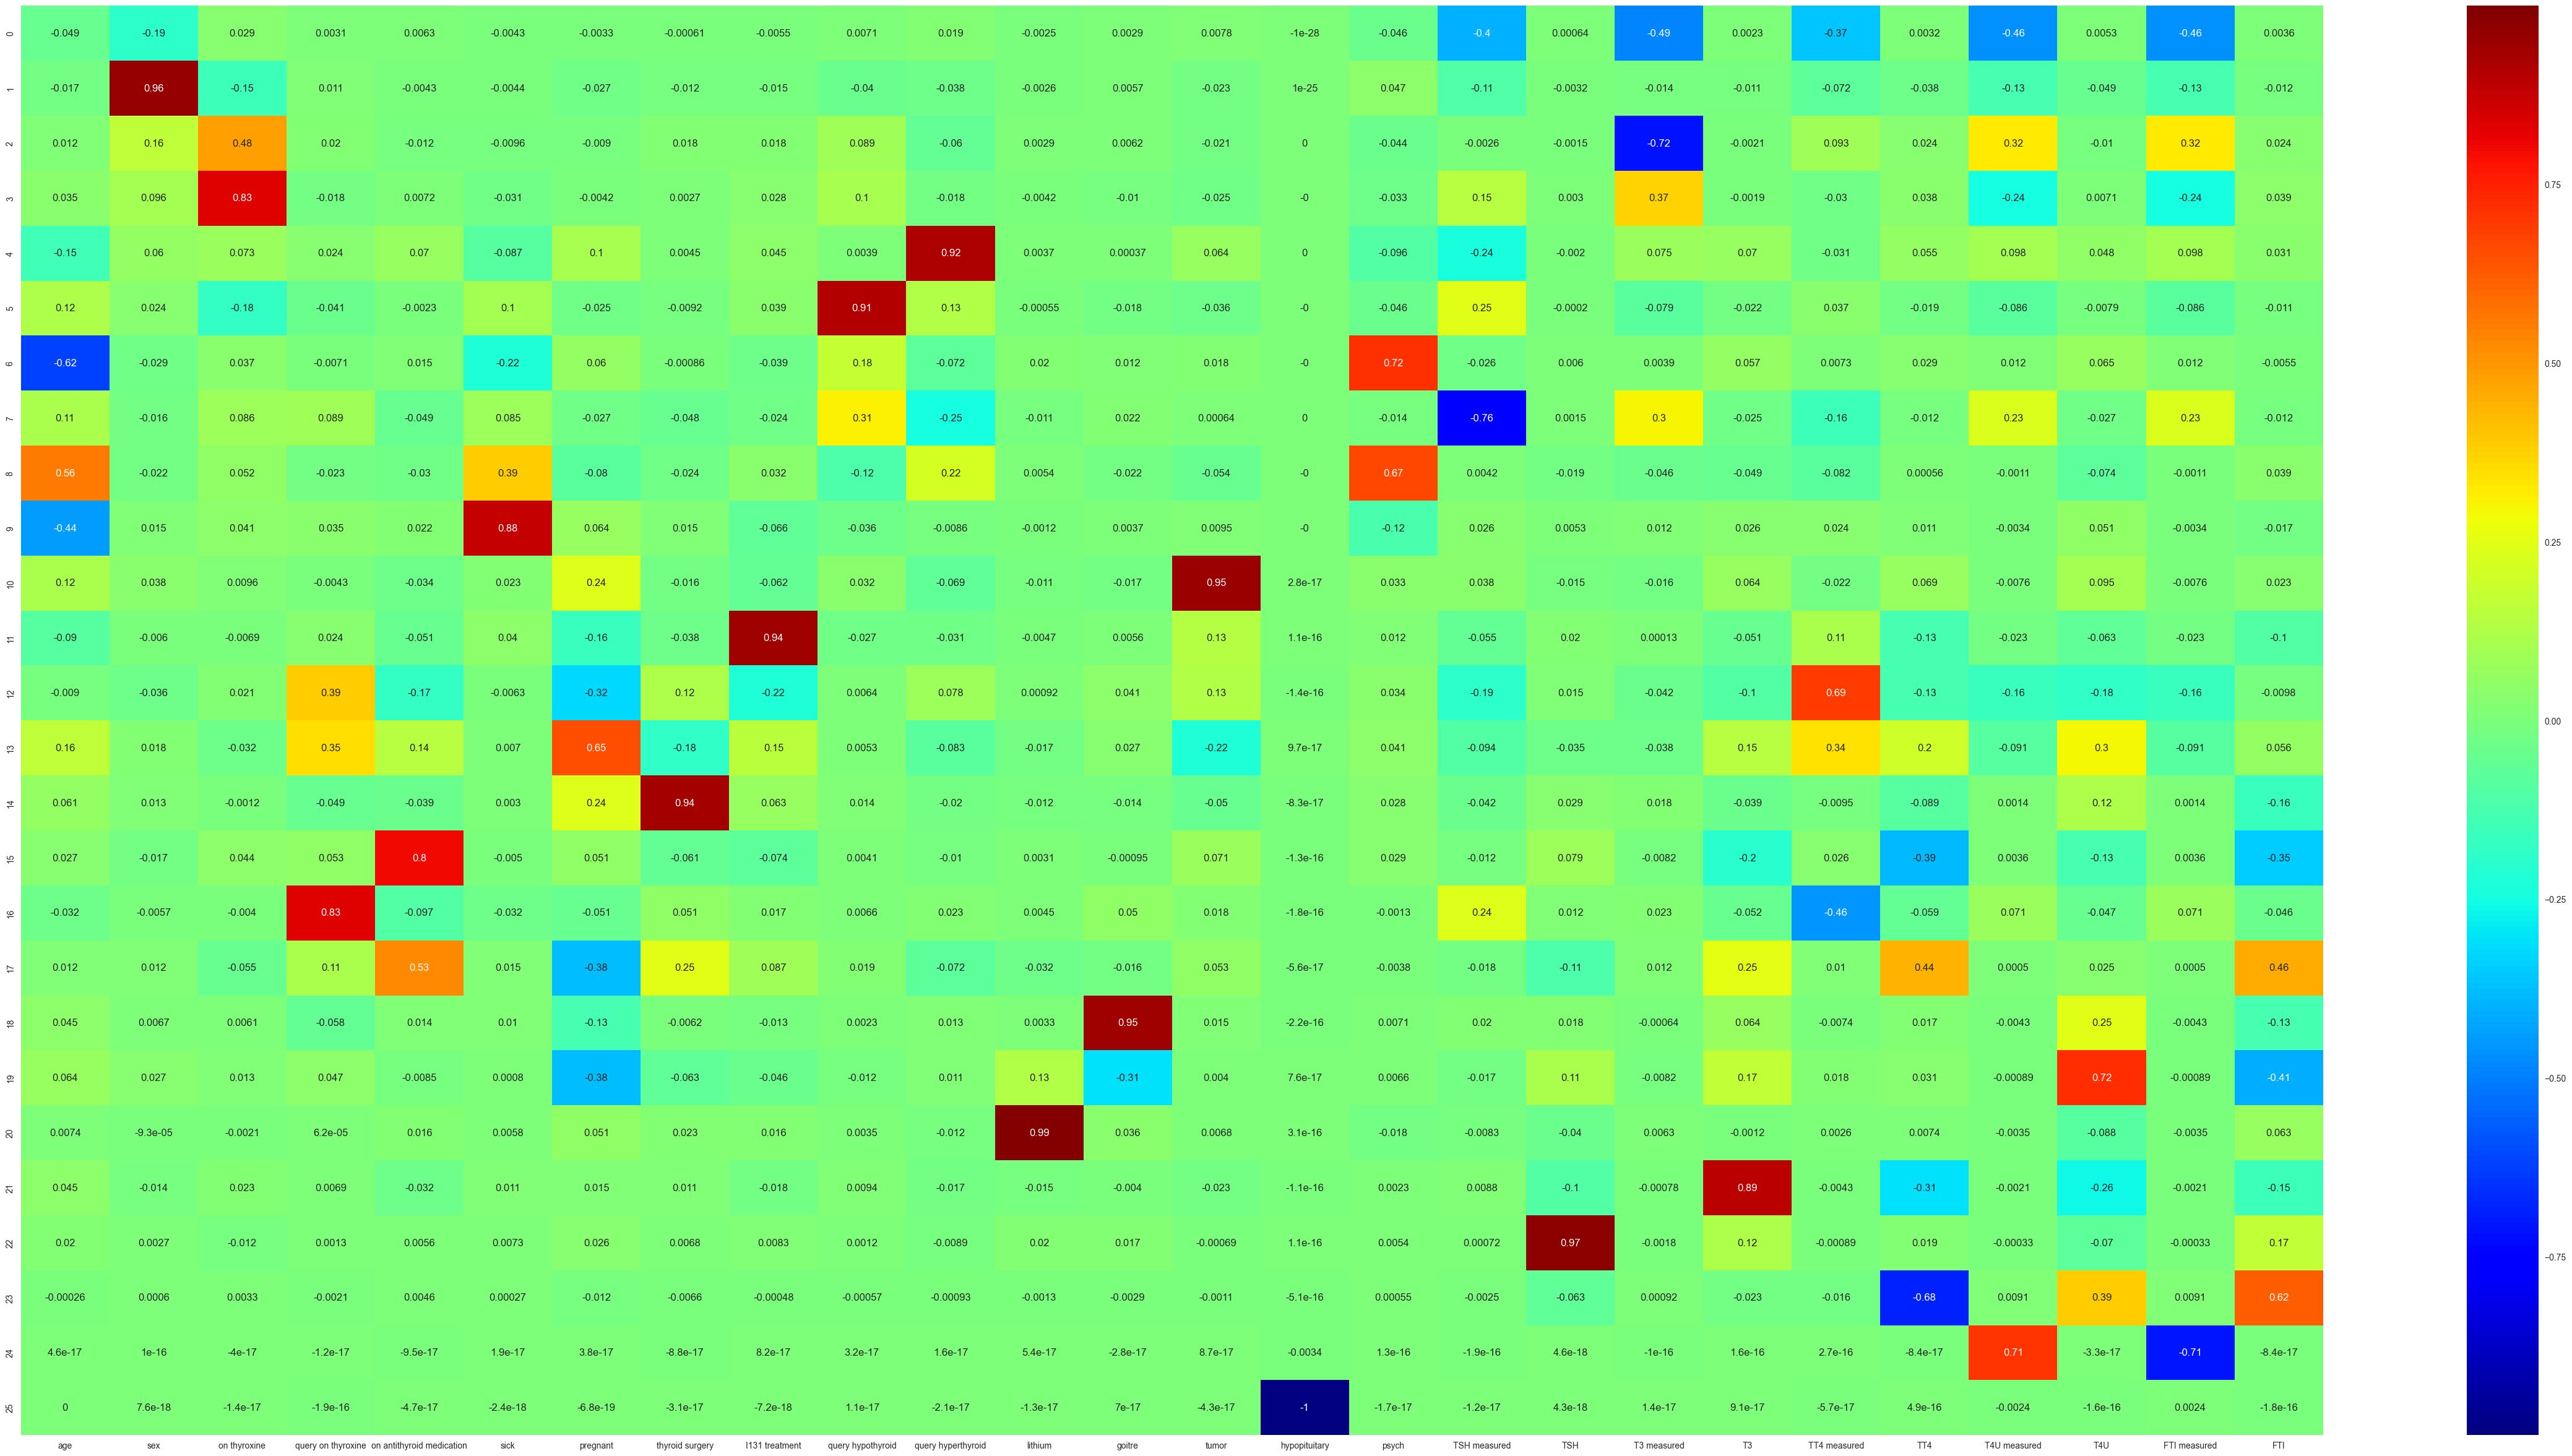

In [164]:
fig, ax = plt.subplots(figsize=(60,30))
sns.heatmap(myPCA.components_, cmap='jet', xticklabels=list(X_train_standarized.columns[:]), vmin=-np.max(np.abs(myPCA.components_)), vmax=np.max(np.abs(myPCA.components_)),annot=True);

#### Transformamos nuestro conjunto de datos utilizando el PCA

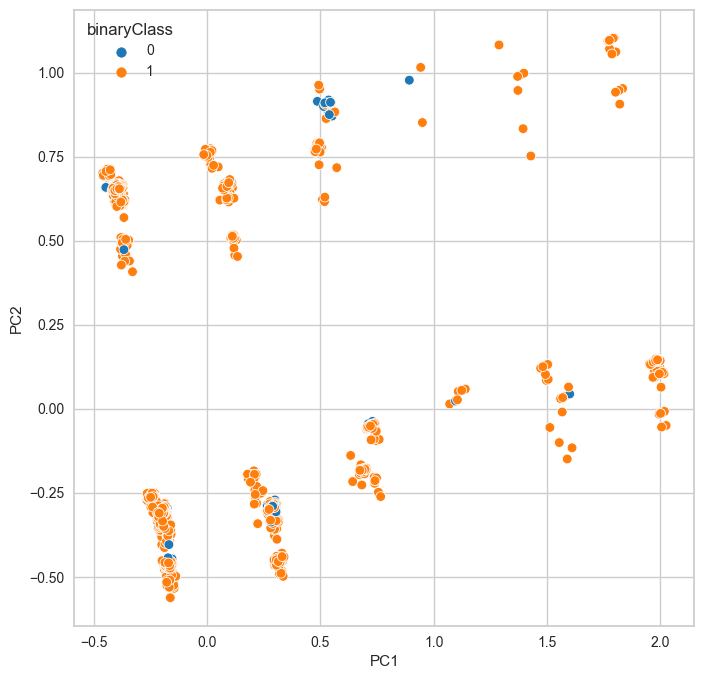

In [165]:
transformed_train = myPCA.transform(X_train_standarized[X_train.columns])

X_train_standarized[['PC1','PC2','PC3']] = transformed_train[:,:3]

fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', data=X_train_standarized, hue=y_train, palette='tab10')

In [166]:
import plotly.express as px

fig = px.scatter_3d(X_train_standarized, x='PC1', y='PC2', z='PC3',color=y_train)
fig.show()

A simple vista no queda claro muy bien la separación que está realizando el PCA. Podemo probar de intentar capturar algunas no-linealidades usando el t-SNE

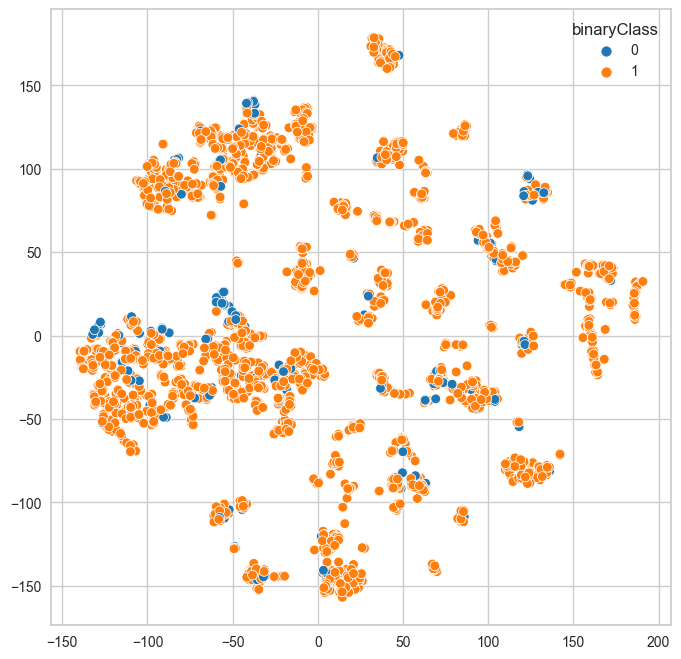

In [168]:
from sklearn.manifold import TSNE

transformed_train = TSNE(n_components=2, perplexity=10, init='pca').fit_transform(X_train_standarized[X_train.columns])

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=transformed_train[:,0], y=transformed_train[:,1], hue=y_train, palette='tab10');

In [169]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Aplicación de los distintos modelos lineales

* Regresión logística
* regresión multinomial (perceptrón de una sola capa)
* LDA, QDA
* Naive Bayes
* k-vecinos más cercanos
* SVM lineal, SVM cuadrático

#### Regresión logística

In [170]:
# lr = LogisticRegression()
#
# param_grid = {'C': [0.1, 1, 10, 100],
#               'penalty': ['l1', 'l2'],
#               'solver': ['liblinear', 'saga'],
#               'max_iter': [100, 200, 300, 400, 500]}
#
# lr_bs = BayesSearchCV(lr, param_grid, cv=10, n_jobs=-1, refit=True)
# lr_bs.fit(X_train, y_train)

/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarn

BayesSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
              search_spaces={'C': [0.1, 1, 10, 100],
                             'max_iter': [100, 200, 300, 400, 500],
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga']})

In [171]:
# print(np.mean(cross_val_score(lr_bs,X_train,y_train,cv=10)))

/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarn

KeyboardInterrupt: 

In [ ]:
# show_html(pd.DataFrame(lr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
# print(classification_report(lr_bs.predict(X_test), y_test,target_names=clases))
# results_df = save_results(lr_bs, X_test, y_test, 'Linear regression', results_df)

In [ ]:
# plt.figure(figsize=(8,8))
# ConfusionMatrixDisplay.from_estimator(lr_bs, X_test,y_test, display_labels=clases, ax=plt.subplot());

In [ ]:
# plt.figure(figsize=(8,8))
# roc_auc(lr_bs, X_train, y_train, X_test, y_test, classes=clases);

#### LDA

In [173]:
lda = LinearDiscriminantAnalysis()

# Define the parameter grid
param_grid = {'solver': ['svd', 'lsqr'],
              'shrinkage': [None, 'auto', 0.1, 0.2, 0.3, 0.4, 0.5],
              'n_components': [None, 1, 2, 3, 4, 5],
              'tol': [1e-3, 1e-4, 1e-5],
              'store_covariance': [True, False]}

lda_gs =  GridSearchCV(lda, param_grid,cv=10, n_jobs=-1, refit=True)
lda_gs.fit(X_train, y_train)

In [174]:
print(np.mean(cross_val_score(lda_gs,X_train,y_train,cv=10)))

0.9406481705573034


In [175]:
show_html(pd.DataFrame(lda_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
102,"{'n_components': 1, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.001}",0.940648,1
21,"{'n_components': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': False, 'tol': 0.001}",0.940648,1
20,"{'n_components': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 1e-05}",0.940648,1
19,"{'n_components': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.0001}",0.940648,1
18,"{'n_components': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.001}",0.940648,1


In [176]:
print(classification_report(lda_gs.predict(X_test), y_test,target_names=clases))
results_df = save_results(lda_gs, X_test, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

           0       0.33      0.90      0.48        21
           1       1.00      0.95      0.97       734

    accuracy                           0.95       755
   macro avg       0.66      0.93      0.73       755
weighted avg       0.98      0.95      0.96       755



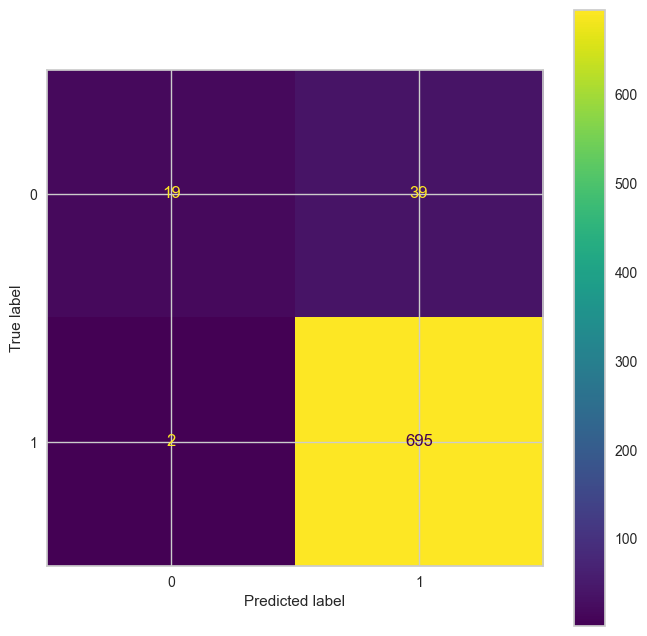

In [177]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lda_gs, X_test,y_test, display_labels=clases, ax=plt.subplot());

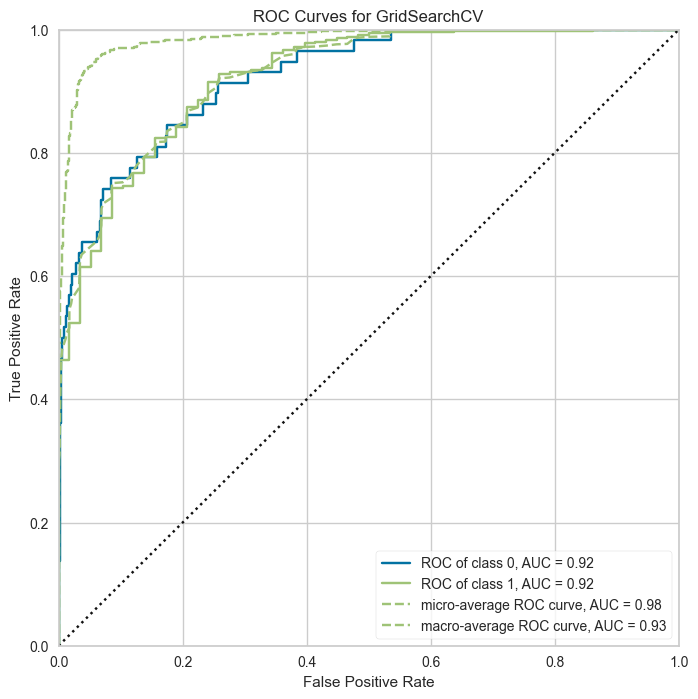

In [178]:
plt.figure(figsize=(8,8))
roc_auc(lda_gs, X_train, y_train, X_test, y_test, classes=clases);

#### QDA

In [179]:
qda = QuadraticDiscriminantAnalysis()

# Define the parameter grid
param_grid = {'shrinkage': [None, 'auto', 0.1, 0.2, 0.3, 0.4, 0.5],
              'n_components': [None, 1, 2, 3, 4, 5],
              'solver': ['svd', 'lsqr', 'eigen'],
              'store_covariance': [True, False],
              'tol': [1e-3, 1e-4, 1e-5],
              'store_covariance': [True, False]}

# Create the grid search object
qda_gs =  GridSearchCV(lda, param_grid, cv=10, n_jobs=-1, refit=True)
qda_gs.fit(X_train, y_train);

In [180]:
print(np.mean(cross_val_score(qda_gs,X_train,y_train,cv=10)))

0.9406481705573034


In [181]:
show_html(pd.DataFrame(qda_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
156,"{'n_components': 1, 'shrinkage': 'auto', 'solver': 'eigen', 'store_covariance': True, 'tol': 0.001}",0.940648,1
158,"{'n_components': 1, 'shrinkage': 'auto', 'solver': 'eigen', 'store_covariance': True, 'tol': 1e-05}",0.940648,1
159,"{'n_components': 1, 'shrinkage': 'auto', 'solver': 'eigen', 'store_covariance': False, 'tol': 0.001}",0.940648,1
160,"{'n_components': 1, 'shrinkage': 'auto', 'solver': 'eigen', 'store_covariance': False, 'tol': 0.0001}",0.940648,1
161,"{'n_components': 1, 'shrinkage': 'auto', 'solver': 'eigen', 'store_covariance': False, 'tol': 1e-05}",0.940648,1


In [182]:
print(classification_report(qda_gs.predict(X_test), y_test,target_names=clases))
results_df = save_results(qda_gs, X_test, y_test, 'QDA', results_df)

              precision    recall  f1-score   support

           0       0.33      0.90      0.48        21
           1       1.00      0.95      0.97       734

    accuracy                           0.95       755
   macro avg       0.66      0.93      0.73       755
weighted avg       0.98      0.95      0.96       755



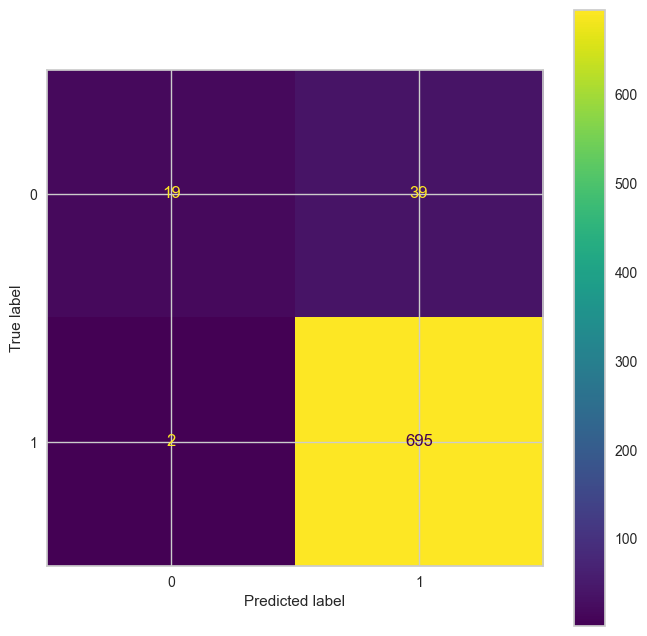

In [183]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(qda_gs, X_test,y_test, display_labels=clases, ax=plt.subplot());

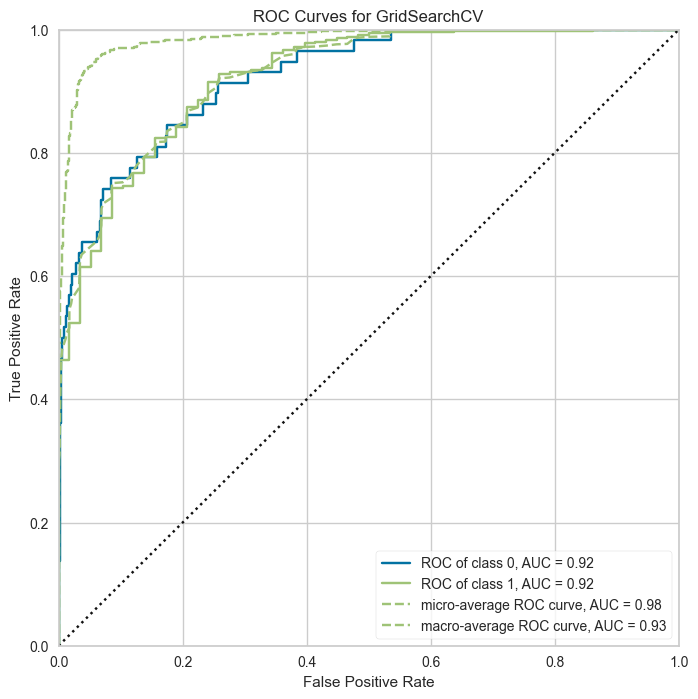

In [184]:
plt.figure(figsize=(8,8))
roc_auc(qda_gs, X_train, y_train, X_test, y_test, classes=clases);

#### Naive Bayes

In [185]:
gnb = GaussianNB()
print(np.mean(cross_val_score(gnb,X_train,y_train,cv=10)))

gnb_model = GaussianNB().fit(X_train, y_train)

0.22049569866449584


In [186]:
print(classification_report(gnb_model.predict(X_test), y_test,target_names=clases))
results_df = save_results(gnb_model, X_test, y_test, 'Naïve Bayes', results_df)

              precision    recall  f1-score   support

           0       0.98      0.09      0.16       647
           1       0.15      0.99      0.27       108

    accuracy                           0.22       755
   macro avg       0.57      0.54      0.21       755
weighted avg       0.86      0.22      0.18       755



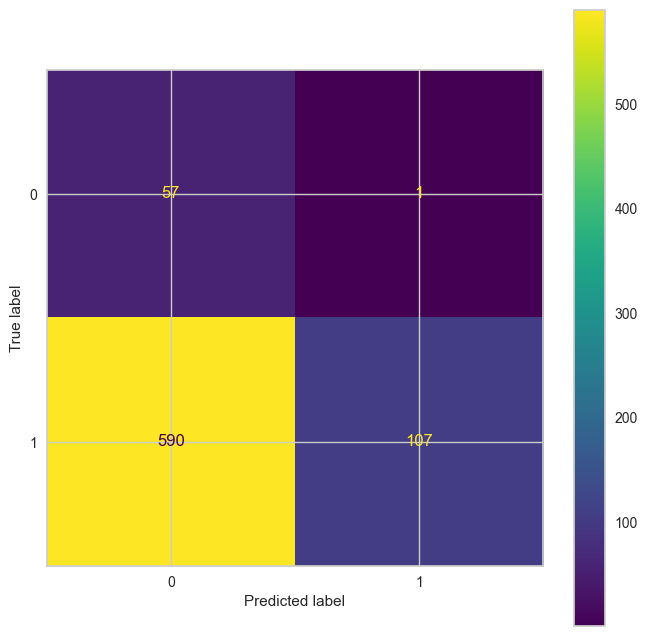

In [187]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=clases, ax=plt.subplot());

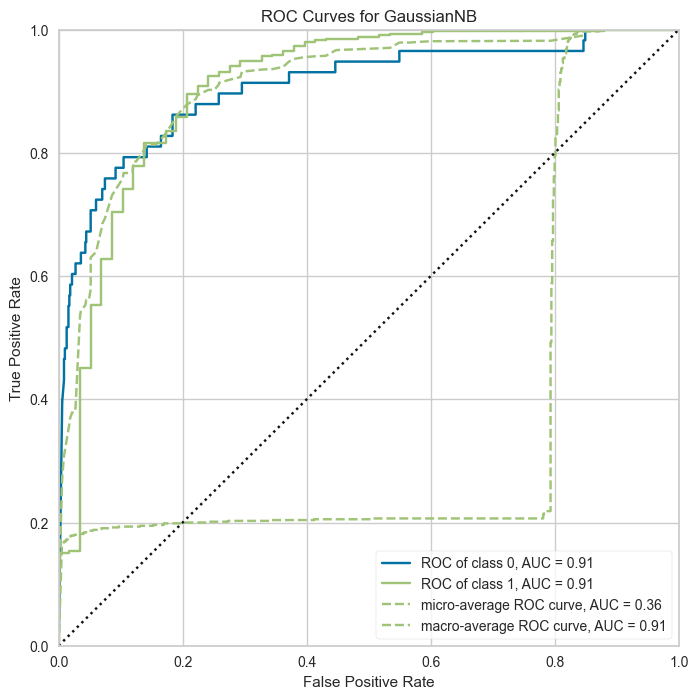

In [188]:
plt.figure(figsize=(8,8))
roc_auc(gnb_model, X_train, y_train, X_test, y_test, classes=clases);

#### KNN

In [189]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [190]:
knn =  KNeighborsClassifier()
print(np.mean(cross_val_score(knn,X_train_s,y_train,cv=10)))

0.9353457569690438


In [191]:
param = {'n_neighbors':[1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 20, 30, 40, 50], 
          'weights':['distance', 'uniform'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'p': [1, 2, 3, 4, 5],
          'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'l2', 'l1'],
          'leaf_size':[1, 5, 10, 20, 30]}

knn_gs =  BayesSearchCV(knn,param,cv=10, n_jobs=-1)
knn_gs.fit(X_train_s, y_train);

In [192]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
49,"{'algorithm': 'brute', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.939983,1
18,"{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.939983,1
25,"{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 5, 'p': 5, 'weights': 'distance'}",0.939983,1
48,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.939983,1
22,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.939318,5


In [193]:
print(classification_report(knn_gs.predict(X_test_s), y_test,target_names=clases))
results_df = save_results(knn_gs, X_test, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

           0       0.24      0.78      0.37        18
           1       0.99      0.94      0.97       737

    accuracy                           0.94       755
   macro avg       0.62      0.86      0.67       755
weighted avg       0.98      0.94      0.95       755



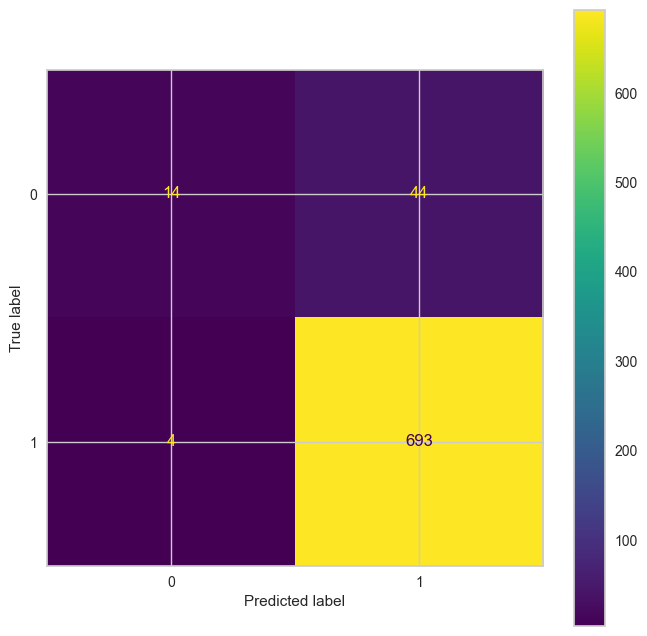

In [194]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, display_labels=clases, ax=plt.subplot());

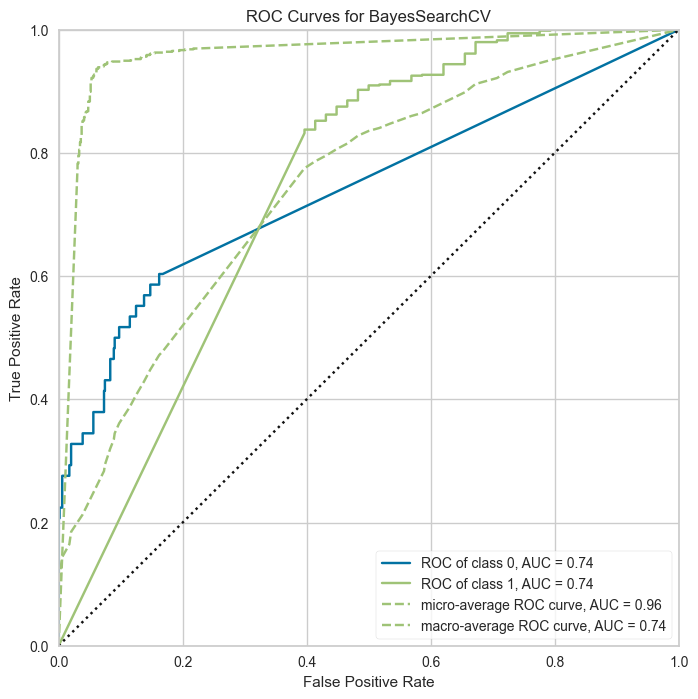

In [195]:
plt.figure(figsize=(8,8))
roc_auc(knn_gs, X_train_s, y_train, X_test_s, y_test, classes=clases);

#### SVM lineal

In [196]:
param = {'C': [0.1, 1, 10, 100, 1000, 10000, 100000],
         'tol': [1e-3, 1e-4, 1e-5, 1e-6],
         'shrinking': [True,False],
         'gamma': [1e-3, 1e-4, 1e-5],
         'cache_size': [200, 500, 1000]}

lsvc =  SVC(kernel='linear', max_iter=25000000, random_state=42)
lsvc_gs = BayesSearchCV(lsvc,param,n_iter=15, cv=10, n_jobs=-1, refit=True, random_state=42);
lsvc_gs.fit(X_train_s, y_train);

/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solv

In [197]:
show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
1,"{'C': 10000.0, 'cache_size': 1000, 'gamma': 0.0001, 'shrinking': True, 'tol': 0.001}",0.974134,1
3,"{'C': 10000.0, 'cache_size': 200, 'gamma': 0.0001, 'shrinking': True, 'tol': 0.0001}",0.974134,1
4,"{'C': 10000.0, 'cache_size': 500, 'gamma': 0.0001, 'shrinking': True, 'tol': 0.001}",0.974134,1
8,"{'C': 100000.0, 'cache_size': 500, 'gamma': 0.001, 'shrinking': False, 'tol': 1e-05}",0.973470,4
5,"{'C': 1000.0, 'cache_size': 1000, 'gamma': 1e-05, 'shrinking': False, 'tol': 0.0001}",0.973141,5


In [198]:
print(classification_report(lsvc_gs.predict(X_test_s), y_test,target_names=clases))
results_df = save_results(lsvc_gs, X_test_s, y_test, 'SVM Linear', results_df)

              precision    recall  f1-score   support

           0       0.76      0.96      0.85        46
           1       1.00      0.98      0.99       709

    accuracy                           0.98       755
   macro avg       0.88      0.97      0.92       755
weighted avg       0.98      0.98      0.98       755



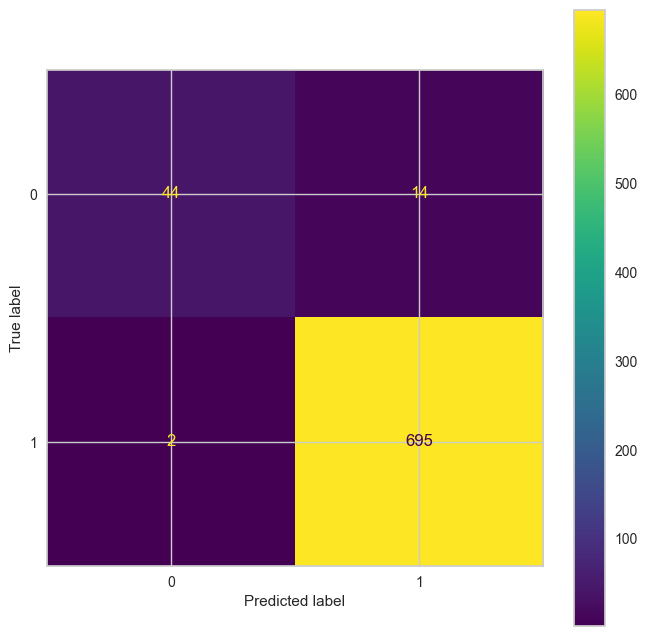

In [199]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lsvc_gs, X_test_s, y_test, display_labels=clases, ax=plt.subplot());

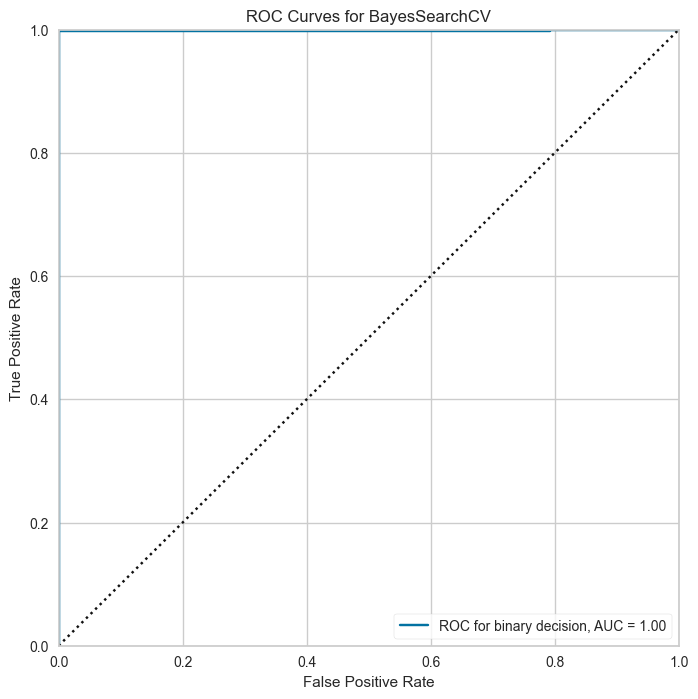

In [201]:
plt.figure(figsize=(8,8))
roc_auc(lsvc_gs, X_train_s, y_train, X_test_s, y_test, classes=clases, binary=True);